In [1]:
!pip install GDAL

In [2]:
import os
import torch.nn.functional as F 
import numpy as np
from osgeo import gdal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.interpolate import griddata

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Đặt seed để tái lập kết quả
torch.manual_seed(42)
np.random.seed(42)

# Định nghĩa các hằng số và đường dẫn
BASE_PATH = "/kaggle/input/btl-ai/DATA_SV"
HIMA_PATH = os.path.join(BASE_PATH, "Hima")
ERA5_PATH = os.path.join(BASE_PATH, "ERA5")
PRECIP_PATH = os.path.join(BASE_PATH, "Precipitation/Radar")
OUTPUT_PATH = "/kaggle/working/output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
HIMA_BANDS = ['B04B', 'B05B', 'B09B', 'B10B', 'B12B', 'B16B', 'VSB', 'WVB']  # 13 band
ERA5_PARAMS = ['CAPE', 'CIN', 'EWSS', 'ISOR', 'KX', 'R250', 'R500', 'R850', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']  # 8 tham số
HEIGHT, WIDTH = 90, 250
IN_CHANNEL = len(HIMA_BANDS) + len(ERA5_PARAMS)

DOWNSCALE_FACTOR = 2
NEW_HEIGHT, NEW_WIDTH = HEIGHT // DOWNSCALE_FACTOR, WIDTH // DOWNSCALE_FACTOR

In [6]:
# 2. Hàm xử lý dữ liệu
# Hàm đọc file GeoTIFF
import numpy as np

def read_geotiff(file_path, data_type="Radar", verbose=False):
    try:
        ds = gdal.Open(file_path)
        band = ds.GetRasterBand(1)
        nodata = band.GetNoDataValue()  # Lấy giá trị nodata
        data = band.ReadAsArray().astype(np.float32)
        ds = None
        
        # Kiểm tra kích thước
        HEIGHT, WIDTH = 90, 250  # Giả định HEIGHT và WIDTH đã được định nghĩa
        if data.shape != (HEIGHT, WIDTH):
            print(f"Invalid shape {data.shape} for file {file_path}, expected ({HEIGHT}, {WIDTH})")
            return None
        
        # Kiểm tra và xử lý giá trị nodata
        if nodata is not None:
            nodata_count = np.sum(data == nodata)
            # if verbose:
            #     print(f"Number of missing values in {file_path}: {nodata_count}")
            
            # Xử lý giá trị thiếu tùy theo loại dữ liệu
            if data_type == "Radar":
                data[data == nodata] = 0  # Điền bằng 0 cho lượng mưa
            elif data_type == "Hima":
                # Điền bằng giá trị trung bình
                mask = data != nodata
                if np.any(mask):
                    mean_value = np.mean(data[mask])
                    data[data == nodata] = mean_value
            elif data_type == "ERA5":
                # Điền bằng nội suy
                mask = data == nodata
                if np.any(mask):
                    points = np.array([(i, j) for i in range(data.shape[0]) for j in range(data.shape[1]) if not mask[i, j]])
                    values = data[~mask]
                    xi = np.array([(i, j) for i in range(data.shape[0]) for j in range(data.shape[1]) if mask[i, j]])
                    interpolated_values = griddata(points, values, xi, method='nearest')
                    for idx, (i, j) in enumerate(xi):
                        data[xi[idx][0], xi[idx][1]] = interpolated_values[idx]
        
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [7]:
# Hàm phân tích thời gian từ tên file
def parse_datetime_from_filename(filename, data_type):
    try:
        if data_type == "Hima":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].split('_TB.tif')[0]
            time_part = time_part.replace('.Z', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M')
        elif data_type == "ERA5":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        elif data_type == "Radar":
            time_part = filename.split('_')[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        else:
            return None
        return dt.replace(minute=0, second=0, microsecond=0)
    except Exception as e:
        global error_count
        if error_count < 5:
            print(f"Error parsing datetime from {filename} (type {data_type}): {e}")
            error_count += 1
        return None

In [8]:
error_count = 0

# Hàm thu thập file
def collect_files(base_path, expected_subdirs=None, data_type=None):
    files_dict = {}
    file_count = 0
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.tif'):
                file_path = os.path.join(root, file)
                dt = parse_datetime_from_filename(file, data_type)
                if dt is None:
                    continue
                file_count += 1
                if expected_subdirs:
                    subdir = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(file_path)))))
                    if dt not in files_dict:
                        files_dict[dt] = {}
                    files_dict[dt][subdir] = file_path
                else:
                    files_dict[dt] = file_path
    print(f"Found {file_count} files in {base_path}")
    return files_dict

In [9]:
# Hàm xử lý dữ liệu thiếu và chuẩn hóa
def preprocess_data(data, data_type):
    if data is None:
        return None
    # Xử lý giá trị không hợp lệ
    data = np.where(np.isinf(data) | np.isnan(data) | (data == -9999), 0, data)
    if data_type == "Radar":
        # Log transformation cho radar
        data = np.log1p(np.maximum(data, 0))  # log(1 + x)
    else:
        # Min-max scaling cho Himawari và ERA5
        data_min, data_max = np.min(data), np.max(data)
        if data_max > data_min:
            data = (data - data_min) / (data_max - data_min)
        else:
            data = np.zeros_like(data)
    return data

In [10]:
# Bắt đầu chương trình
print("Collecting Himawari files...")
hima_files = {}
for band in HIMA_BANDS:
    band_path = os.path.join(HIMA_PATH, band)
    if not os.path.exists(band_path):
        print(f"Directory not found: {band_path}")
        continue
    band_files = collect_files(band_path, expected_subdirs=HIMA_BANDS, data_type="Hima")
    for dt, paths in band_files.items():
        if dt not in hima_files:
            hima_files[dt] = {}
        hima_files[dt][band] = paths[band]

Found 1438 files in /kaggle/input/btl-ai/DATA_SV/Hima/B04B
Found 1361 files in /kaggle/input/btl-ai/DATA_SV/Hima/B05B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B09B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B10B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B12B
Found 2776 files in /kaggle/input/btl-ai/DATA_SV/Hima/B16B
Found 1448 files in /kaggle/input/btl-ai/DATA_SV/Hima/VSB
Found 2774 files in /kaggle/input/btl-ai/DATA_SV/Hima/WVB


In [11]:
print("Collecting ERA5 files...")
era5_files = {}
for param in ERA5_PARAMS:
    param_path = os.path.join(ERA5_PATH, param)
    if not os.path.exists(param_path):
        print(f"Directory not found: {param_path}")
        continue
    param_files = collect_files(param_path, expected_subdirs=ERA5_PARAMS, data_type="ERA5")
    for dt, paths in param_files.items():
        if dt not in era5_files:
            era5_files[dt] = {}
        era5_files[dt][param] = paths[param]

Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/CAPE
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/CIN
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/EWSS
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/ISOR
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/KX
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R250
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R500
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R850
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCLW
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCW
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCWV
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/U250
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/U850
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/V250
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/V850


In [12]:
print("Collecting Precipitation files...")
precip_files = collect_files(PRECIP_PATH, data_type="Radar")

Found 2487 files in /kaggle/input/btl-ai/DATA_SV/Precipitation/Radar


In [13]:
def find_nearest_available(dt, band):
    # Tìm các timestamp gần nhất có dữ liệu
    timestamps = sorted(hima_files.keys())
    idx = timestamps.index(dt)
    
    # Tìm trước và sau
    prev_data, next_data = None, None
    for i in range(idx-1, -1, -1):
        if band in hima_files[timestamps[i]]:
            prev_data = read_geotiff(hima_files[timestamps[i]][band], "Hima")
            prev_data = preprocess_data(prev_data, "Hima")
            break
    for i in range(idx+1, len(timestamps)):
        if band in hima_files[timestamps[i]]:
            next_data = read_geotiff(hima_files[timestamps[i]][band], "Hima")
            next_data = preprocess_data(next_data, "Hima")
            break
    
    # Nội suy tuyến tính
    if prev_data and next_data:
        return (prev_data + next_data) / 2
    elif prev_data:
        return prev_data
    elif next_data:
        return next_data
    else:
        return np.zeros((HEIGHT, WIDTH))

In [14]:
def compute_means():
    hima_means = {}
    for band in HIMA_BANDS:
        all_vals = []
        for dt in hima_files:
            if band in hima_files[dt]:
                try:
                    path = hima_files[dt][band]
                    data = read_geotiff(path, data_type="Hima")
                    data = preprocess_data(data, data_type="Hima")
                    all_vals.append(data)
                except:
                    continue
        if all_vals:
            stacked = np.stack(all_vals)
            hima_means[band] = np.nanmean(stacked)
        else:
            hima_means[band] = 0.0  # fallback default
        print(f"Computed HIMA mean for {band}: {hima_means[band]}")

    era5_means = {}
    for param in ERA5_PARAMS:
        all_vals = []
        for dt in era5_files:
            if param in era5_files[dt]:
                try:
                    path = era5_files[dt][param]
                    data = read_geotiff(path, data_type="ERA5")
                    data = preprocess_data(data, data_type="ERA5")
                    all_vals.append(data)
                except:
                    continue
        if all_vals:
            stacked = np.stack(all_vals)
            era5_means[param] = np.nanmean(stacked)
        else:
            era5_means[param] = 0.0
        print(f"Computed ERA5 mean for {param}: {era5_means[param]}")

    radar_vals = []
    for dt in precip_files:
        try:
            path = precip_files[dt]
            data = read_geotiff(path, data_type="Radar")
            data = preprocess_data(data, data_type="Radar")
            radar_vals.append(data)
        except:
            continue
    if radar_vals:
        radar_stacked = np.stack(radar_vals)
        radar_mean = np.nanmean(radar_stacked)
    else:
        radar_mean = 0.0
    print(f"Computed Radar mean: {radar_mean}")

    return hima_means, era5_means, radar_mean


In [15]:
hima_means = {
    "B04B": 0.3693857192993164,
    "B05B": 0.3864578306674957,
    "B09B": 0.7314290404319763,
    "B10B": 0.7606856226921082,
    "B12B": 0.7226250171661377,
    "B16B": 0.7668702006340027,
    "VSB": 0.28368034958839417,
    "WVB": 0.7009843587875366,
}

era5_means = {
    "CAPE": 0.19077764451503754,
    "CIN": 0.484561949968338,
    "EWSS": 0.566582202911377,
    "ISOR": 0.3529810607433319,
    "KX": 0.6273183226585388,
    "R250": 0.4019862115383148,
    "R500": 0.42741867899894714,
    "R850": 0.6081112623214722,
    "TCLW": 0.16915756464004517,
    "TCW": 0.5383413434028625,
    "TCWV": 0.5471685528755188,
    "U250": 0.4965469241142273,
    "U850": 0.5042932033538818,
    "V250": 0.4843064844608307,
    "V850": 0.5125048756599426,
}

radar_mean = 0.03901957347989082


In [16]:
import os
from tqdm import tqdm  # để hiện tiến trình
def flatten_datetime_sample(dt, hima_means, era5_means, radar_mean):
    hima_bands = []
    for band in HIMA_BANDS:
        if dt in hima_files and band in hima_files[dt]:
            path = hima_files[dt][band]
            data = read_geotiff(path, data_type="Hima")
            data = preprocess_data(data, data_type="Hima")
        else:
            print(f"[{dt}] Warning: Missing Himawari band {band}, filling with MEAN")
            data = np.full((HEIGHT, WIDTH), hima_means[band], dtype=np.float32)
        hima_bands.append(data)

    era5_bands = []
    for param in ERA5_PARAMS:
        if dt in era5_files and param in era5_files[dt]:
            path = era5_files[dt][param]
            data = read_geotiff(path, data_type="ERA5")
            data = preprocess_data(data, data_type="ERA5")
        else:
            print(f"[{dt}] Warning: Missing ERA5 param {param}, filling with MEAN")
            data = np.full((HEIGHT, WIDTH), era5_means[param], dtype=np.float32)
        era5_bands.append(data)

    if dt in precip_files:
        radar_path = precip_files[dt]
        radar_data = read_geotiff(radar_path, data_type="Radar")
        radar_data = preprocess_data(radar_data, data_type="Radar")
    else:
        print(f"[{dt}] Warning: Missing Radar, filling with MEAN")
        radar_data = np.full((HEIGHT, WIDTH), radar_mean, dtype=np.float32)

    combined = np.stack(hima_bands + era5_bands + [radar_data], axis=2)
    flattened = combined.flatten(order='C')
    return flattened
def process_all_timesteps(output_dir=OUTPUT_PATH):
    all_datetimes = sorted(set(hima_files.keys()) | set(era5_files.keys()) | set(precip_files.keys()))
    print(f"Processing {len(all_datetimes)} timesteps...")

    os.makedirs(output_dir, exist_ok=True)

    for dt in tqdm(all_datetimes):
        try:
            flattened = flatten_datetime_sample(dt, hima_means, era5_means, radar_mean)
            filename = f"flattened_{dt.strftime('%Y%m%d%H')}.npy"
            np.save(os.path.join(output_dir, filename), flattened)
        except Exception as e:
            print(f"[{dt}] Error: {e}")

    print("✅ Done processing all timesteps!")



In [17]:
process_all_timesteps()


Processing 2928 timesteps...


  0%|          | 12/2928 [00:03<12:19,  3.94it/s]

[2019-04-01 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  0%|          | 13/2928 [00:03<11:51,  4.10it/s]

[2019-04-01 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  0%|          | 14/2928 [00:03<11:34,  4.20it/s]

[2019-04-01 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|          | 16/2928 [00:04<10:38,  4.56it/s]

[2019-04-01 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-01 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-01 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  1%|          | 17/2928 [00:04<10:55,  4.44it/s]

[2019-04-01 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-01 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  1%|          | 18/2928 [00:04<10:41,  4.54it/s]

[2019-04-01 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-01 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  1%|          | 19/2928 [00:04<10:25,  4.65it/s]

[2019-04-01 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-01 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  1%|          | 20/2928 [00:04<10:14,  4.73it/s]

[2019-04-01 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-01 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|          | 21/2928 [00:05<10:23,  4.66it/s]

[2019-04-01 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|          | 22/2928 [00:05<10:33,  4.58it/s]

[2019-04-01 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|          | 23/2928 [00:05<10:33,  4.59it/s]

[2019-04-01 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-01 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-01 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|          | 36/2928 [00:08<12:19,  3.91it/s]

[2019-04-02 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|▏         | 37/2928 [00:09<11:41,  4.12it/s]

[2019-04-02 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|▏         | 39/2928 [00:09<11:19,  4.25it/s]

[2019-04-02 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|▏         | 40/2928 [00:09<10:49,  4.44it/s]

[2019-04-02 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  1%|▏         | 42/2928 [00:10<10:20,  4.65it/s]

[2019-04-02 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  1%|▏         | 43/2928 [00:10<10:13,  4.70it/s]

[2019-04-02 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 44/2928 [00:10<10:10,  4.72it/s]

[2019-04-02 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 45/2928 [00:10<10:08,  4.74it/s]

[2019-04-02 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 46/2928 [00:10<10:05,  4.76it/s]

[2019-04-02 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 47/2928 [00:11<10:08,  4.74it/s]

[2019-04-02 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-02 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-02 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-02 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 60/2928 [00:14<11:52,  4.02it/s]

[2019-04-03 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 61/2928 [00:14<11:29,  4.16it/s]

[2019-04-03 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 63/2928 [00:14<11:08,  4.29it/s]

[2019-04-03 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 64/2928 [00:15<10:58,  4.35it/s]

[2019-04-03 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 65/2928 [00:15<10:43,  4.45it/s]

[2019-04-03 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 66/2928 [00:15<10:33,  4.52it/s]

[2019-04-03 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 67/2928 [00:15<10:26,  4.56it/s]

[2019-04-03 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 68/2928 [00:16<10:39,  4.47it/s]

[2019-04-03 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  2%|▏         | 70/2928 [00:16<10:08,  4.70it/s]

[2019-04-03 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-03 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-03 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 71/2928 [00:16<10:10,  4.68it/s]

[2019-04-03 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-03 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-03 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  2%|▏         | 72/2928 [00:16<10:05,  4.72it/s]

[2019-04-03 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 84/2928 [00:19<11:48,  4.01it/s]

[2019-04-04 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 85/2928 [00:20<11:22,  4.17it/s]

[2019-04-04 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 87/2928 [00:20<11:10,  4.24it/s]

[2019-04-04 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 88/2928 [00:20<10:54,  4.34it/s]

[2019-04-04 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 89/2928 [00:21<10:53,  4.34it/s]

[2019-04-04 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 90/2928 [00:21<10:41,  4.43it/s]

[2019-04-04 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 91/2928 [00:21<10:21,  4.57it/s]

[2019-04-04 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 92/2928 [00:21<10:12,  4.63it/s]

[2019-04-04 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 93/2928 [00:21<10:01,  4.71it/s]

[2019-04-04 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  3%|▎         | 95/2928 [00:22<09:46,  4.83it/s]

[2019-04-04 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-04 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-04 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-04 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  3%|▎         | 96/2928 [00:22<09:47,  4.82it/s]

[2019-04-04 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▎         | 108/2928 [00:25<11:47,  3.99it/s]

[2019-04-05 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▎         | 109/2928 [00:25<11:13,  4.18it/s]

[2019-04-05 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 112/2928 [00:26<11:04,  4.24it/s]

[2019-04-05 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 113/2928 [00:26<10:53,  4.31it/s]

[2019-04-05 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 114/2928 [00:26<10:31,  4.46it/s]

[2019-04-05 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 115/2928 [00:27<10:12,  4.60it/s]

[2019-04-05 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 116/2928 [00:27<10:04,  4.65it/s]

[2019-04-05 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 117/2928 [00:27<09:56,  4.71it/s]

[2019-04-05 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 118/2928 [00:27<09:56,  4.71it/s]

[2019-04-05 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  4%|▍         | 119/2928 [00:28<10:14,  4.57it/s]

[2019-04-05 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-05 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-05 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 132/2928 [00:31<12:04,  3.86it/s]

[2019-04-06 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 133/2928 [00:31<11:19,  4.11it/s]

[2019-04-06 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 136/2928 [00:32<10:49,  4.30it/s]

[2019-04-06 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 138/2928 [00:32<10:04,  4.62it/s]

[2019-04-06 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-06 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  5%|▍         | 139/2928 [00:33<10:05,  4.61it/s]

[2019-04-06 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-06 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  5%|▍         | 140/2928 [00:33<10:30,  4.42it/s]

[2019-04-06 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-06 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 141/2928 [00:33<11:26,  4.06it/s]

[2019-04-06 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▍         | 143/2928 [00:34<10:31,  4.41it/s]

[2019-04-06 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-06 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-06 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-06 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  5%|▍         | 144/2928 [00:34<10:25,  4.45it/s]

[2019-04-06 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▌         | 157/2928 [00:37<10:37,  4.35it/s]

[2019-04-07 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-07 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  5%|▌         | 158/2928 [00:37<10:22,  4.45it/s]

[2019-04-07 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▌         | 160/2928 [00:38<11:12,  4.12it/s]

[2019-04-07 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  5%|▌         | 161/2928 [00:38<10:49,  4.26it/s]

[2019-04-07 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 162/2928 [00:38<10:32,  4.37it/s]

[2019-04-07 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 163/2928 [00:38<10:40,  4.32it/s]

[2019-04-07 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 164/2928 [00:39<10:23,  4.44it/s]

[2019-04-07 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 165/2928 [00:39<10:14,  4.50it/s]

[2019-04-07 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 166/2928 [00:39<10:03,  4.58it/s]

[2019-04-07 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 167/2928 [00:39<09:58,  4.61it/s]

[2019-04-07 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-07 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-07 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 180/2928 [00:43<11:29,  3.98it/s]

[2019-04-08 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▌         | 181/2928 [00:43<11:06,  4.12it/s]

[2019-04-08 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 184/2928 [00:43<10:54,  4.20it/s]

[2019-04-08 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 185/2928 [00:44<10:27,  4.37it/s]

[2019-04-08 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 186/2928 [00:44<10:05,  4.53it/s]

[2019-04-08 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 187/2928 [00:44<10:00,  4.57it/s]

[2019-04-08 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 188/2928 [00:44<09:53,  4.61it/s]

[2019-04-08 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 189/2928 [00:45<09:52,  4.62it/s]

[2019-04-08 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  6%|▋         | 190/2928 [00:45<09:54,  4.61it/s]

[2019-04-08 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-08 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 191/2928 [00:45<10:20,  4.41it/s]

[2019-04-08 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-08 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  7%|▋         | 203/2928 [00:48<11:03,  4.11it/s]

[2019-04-09 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  7%|▋         | 204/2928 [00:48<10:50,  4.19it/s]

[2019-04-09 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 206/2928 [00:49<09:58,  4.55it/s]

[2019-04-09 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 208/2928 [00:49<09:56,  4.56it/s]

[2019-04-09 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 209/2928 [00:49<09:52,  4.59it/s]

[2019-04-09 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 210/2928 [00:49<09:42,  4.67it/s]

[2019-04-09 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 211/2928 [00:50<10:16,  4.40it/s]

[2019-04-09 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 213/2928 [00:50<09:41,  4.67it/s]

[2019-04-09 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  7%|▋         | 214/2928 [00:50<09:24,  4.80it/s]

[2019-04-09 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-09 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-09 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-09 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  7%|▋         | 215/2928 [00:51<09:34,  4.72it/s]

[2019-04-09 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-09 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  8%|▊         | 227/2928 [00:53<10:57,  4.11it/s]

[2019-04-10 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  8%|▊         | 229/2928 [00:54<10:19,  4.36it/s]

[2019-04-10 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-10 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  8%|▊         | 230/2928 [00:54<09:49,  4.58it/s]

[2019-04-10 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 232/2928 [00:55<09:56,  4.52it/s]

[2019-04-10 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 233/2928 [00:55<10:00,  4.49it/s]

[2019-04-10 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 234/2928 [00:55<09:54,  4.53it/s]

[2019-04-10 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 235/2928 [00:55<10:14,  4.38it/s]

[2019-04-10 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 236/2928 [00:55<10:10,  4.41it/s]

[2019-04-10 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 237/2928 [00:56<09:59,  4.49it/s]

[2019-04-10 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  8%|▊         | 239/2928 [00:56<08:52,  5.05it/s]

[2019-04-10 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-10 22:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-10 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-10 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-10 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-10 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-10 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

  8%|▊         | 242/2928 [00:57<08:46,  5.10it/s]

[2019-04-11 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-11 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN


  9%|▊         | 252/2928 [00:59<11:04,  4.03it/s]

[2019-04-11 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▊         | 253/2928 [00:59<10:56,  4.08it/s]

[2019-04-11 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▊         | 256/2928 [01:00<11:18,  3.94it/s]

[2019-04-11 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 257/2928 [01:00<10:47,  4.13it/s]

[2019-04-11 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 259/2928 [01:01<10:02,  4.43it/s]

[2019-04-11 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-11 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  9%|▉         | 260/2928 [01:01<09:40,  4.60it/s]

[2019-04-11 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-11 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 261/2928 [01:01<09:39,  4.60it/s]

[2019-04-11 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 262/2928 [01:01<09:40,  4.60it/s]

[2019-04-11 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-11 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 263/2928 [01:02<09:28,  4.68it/s]

[2019-04-11 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-11 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  9%|▉         | 275/2928 [01:05<11:07,  3.97it/s]

[2019-04-12 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


  9%|▉         | 276/2928 [01:05<11:14,  3.93it/s]

[2019-04-12 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


  9%|▉         | 277/2928 [01:05<10:36,  4.16it/s]

[2019-04-12 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|▉         | 280/2928 [01:06<10:23,  4.24it/s]

[2019-04-12 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|▉         | 281/2928 [01:06<10:10,  4.34it/s]

[2019-04-12 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|▉         | 282/2928 [01:06<09:50,  4.48it/s]

[2019-04-12 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|▉         | 283/2928 [01:07<09:50,  4.48it/s]

[2019-04-12 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|▉         | 285/2928 [01:07<09:23,  4.69it/s]

[2019-04-12 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-12 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-12 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 10%|▉         | 286/2928 [01:07<09:38,  4.57it/s]

[2019-04-12 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-12 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-12 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 10%|▉         | 287/2928 [01:08<09:53,  4.45it/s]

[2019-04-12 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-12 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 10%|█         | 296/2928 [01:10<10:39,  4.12it/s]

[2019-04-13 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 10%|█         | 300/2928 [01:11<10:31,  4.16it/s]

[2019-04-13 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|█         | 301/2928 [01:11<10:09,  4.31it/s]

[2019-04-13 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|█         | 302/2928 [01:11<10:16,  4.26it/s]

[2019-04-13 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 10%|█         | 304/2928 [01:12<10:39,  4.11it/s]

[2019-04-13 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|█         | 306/2928 [01:12<09:47,  4.46it/s]

[2019-04-13 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-13 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 10%|█         | 307/2928 [01:12<09:30,  4.59it/s]

[2019-04-13 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 308/2928 [01:12<09:19,  4.69it/s]

[2019-04-13 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 309/2928 [01:13<09:47,  4.46it/s]

[2019-04-13 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 310/2928 [01:13<09:46,  4.46it/s]

[2019-04-13 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-13 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 311/2928 [01:13<09:50,  4.43it/s]

[2019-04-13 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-13 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█         | 324/2928 [01:17<11:14,  3.86it/s]

[2019-04-14 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-14 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 325/2928 [01:17<10:53,  3.98it/s]

[2019-04-14 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-14 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 11%|█         | 326/2928 [01:17<10:42,  4.05it/s]

[2019-04-14 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█         | 329/2928 [01:18<10:07,  4.28it/s]

[2019-04-14 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-14 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 330/2928 [01:18<09:54,  4.37it/s]

[2019-04-14 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 331/2928 [01:18<09:41,  4.46it/s]

[2019-04-14 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 332/2928 [01:18<09:39,  4.48it/s]

[2019-04-14 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 333/2928 [01:19<09:48,  4.41it/s]

[2019-04-14 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 334/2928 [01:19<09:29,  4.56it/s]

[2019-04-14 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-14 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 11%|█▏        | 335/2928 [01:19<09:25,  4.59it/s]

[2019-04-14 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-14 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 12%|█▏        | 348/2928 [01:22<10:27,  4.11it/s]

[2019-04-15 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 349/2928 [01:22<10:03,  4.27it/s]

[2019-04-15 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 350/2928 [01:23<09:48,  4.38it/s]

[2019-04-15 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 352/2928 [01:23<10:00,  4.29it/s]

[2019-04-15 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 353/2928 [01:23<09:46,  4.39it/s]

[2019-04-15 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 355/2928 [01:24<09:09,  4.68it/s]

[2019-04-15 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-15 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 12%|█▏        | 356/2928 [01:24<08:58,  4.77it/s]

[2019-04-15 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-15 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 12%|█▏        | 357/2928 [01:24<09:19,  4.59it/s]

[2019-04-15 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-15 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 12%|█▏        | 358/2928 [01:24<09:13,  4.65it/s]

[2019-04-15 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-15 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 12%|█▏        | 359/2928 [01:25<09:06,  4.70it/s]

[2019-04-15 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-15 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-15 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 372/2928 [01:28<10:25,  4.08it/s]

[2019-04-16 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 373/2928 [01:28<09:52,  4.31it/s]

[2019-04-16 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 375/2928 [01:29<09:41,  4.39it/s]

[2019-04-16 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 376/2928 [01:29<09:47,  4.34it/s]

[2019-04-16 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 377/2928 [01:29<09:42,  4.38it/s]

[2019-04-16 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 378/2928 [01:29<09:45,  4.35it/s]

[2019-04-16 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 379/2928 [01:29<09:33,  4.45it/s]

[2019-04-16 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 380/2928 [01:30<09:21,  4.54it/s]

[2019-04-16 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 381/2928 [01:30<09:15,  4.59it/s]

[2019-04-16 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 382/2928 [01:30<09:08,  4.64it/s]

[2019-04-16 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-16 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-16 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 13%|█▎        | 383/2928 [01:30<09:06,  4.66it/s]

[2019-04-16 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 14%|█▎        | 396/2928 [01:33<10:08,  4.16it/s]

[2019-04-17 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▎        | 397/2928 [01:34<09:51,  4.28it/s]

[2019-04-17 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▎        | 398/2928 [01:34<09:32,  4.42it/s]

[2019-04-17 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▎        | 399/2928 [01:34<09:34,  4.40it/s]

[2019-04-17 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 14%|█▎        | 400/2928 [01:34<09:33,  4.41it/s]

[2019-04-17 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▎        | 401/2928 [01:35<09:21,  4.50it/s]

[2019-04-17 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▎        | 402/2928 [01:35<09:28,  4.44it/s]

[2019-04-17 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 403/2928 [01:35<09:19,  4.51it/s]

[2019-04-17 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 404/2928 [01:35<09:07,  4.61it/s]

[2019-04-17 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 405/2928 [01:35<09:19,  4.51it/s]

[2019-04-17 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 406/2928 [01:36<09:05,  4.62it/s]

[2019-04-17 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-17 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-17 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 407/2928 [01:36<08:58,  4.68it/s]

[2019-04-17 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 14%|█▍        | 420/2928 [01:39<10:17,  4.06it/s]

[2019-04-18 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 421/2928 [01:39<10:33,  3.95it/s]

[2019-04-18 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 14%|█▍        | 423/2928 [01:40<09:20,  4.47it/s]

[2019-04-18 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-18 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 15%|█▍        | 425/2928 [01:40<08:57,  4.65it/s]

[2019-04-18 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-18 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 15%|█▍        | 426/2928 [01:40<08:46,  4.76it/s]

[2019-04-18 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-18 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▍        | 427/2928 [01:41<08:57,  4.66it/s]

[2019-04-18 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▍        | 428/2928 [01:41<08:47,  4.74it/s]

[2019-04-18 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▍        | 429/2928 [01:41<08:42,  4.78it/s]

[2019-04-18 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▍        | 431/2928 [01:41<08:35,  4.84it/s]

[2019-04-18 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-18 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-18 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-18 22:00:00] Warning: Missing Himawari band WVB, filling with MEAN


 15%|█▍        | 432/2928 [01:42<08:39,  4.80it/s]

[2019-04-18 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN


 15%|█▍        | 434/2928 [01:42<10:08,  4.10it/s]

[2019-04-19 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN


 15%|█▌        | 445/2928 [01:45<09:32,  4.33it/s]

[2019-04-19 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-19 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 15%|█▌        | 446/2928 [01:45<09:22,  4.41it/s]

[2019-04-19 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-19 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 15%|█▌        | 447/2928 [01:45<09:03,  4.57it/s]

[2019-04-19 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-19 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 15%|█▌        | 448/2928 [01:45<08:58,  4.60it/s]

[2019-04-19 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▌        | 449/2928 [01:46<09:36,  4.30it/s]

[2019-04-19 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▌        | 450/2928 [01:46<09:36,  4.30it/s]

[2019-04-19 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▌        | 451/2928 [01:46<09:21,  4.41it/s]

[2019-04-19 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▌        | 452/2928 [01:46<09:08,  4.51it/s]

[2019-04-19 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 15%|█▌        | 453/2928 [01:47<08:54,  4.63it/s]

[2019-04-19 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 16%|█▌        | 454/2928 [01:47<08:48,  4.68it/s]

[2019-04-19 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-19 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-19 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 16%|█▌        | 455/2928 [01:47<08:48,  4.68it/s]

[2019-04-19 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▌        | 458/2928 [01:48<08:22,  4.91it/s]

[2019-04-20 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-20 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-20 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-20 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 16%|█▌        | 469/2928 [01:50<09:20,  4.39it/s]

[2019-04-20 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▌        | 470/2928 [01:50<08:53,  4.60it/s]

[2019-04-20 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 16%|█▌        | 471/2928 [01:50<08:39,  4.73it/s]

[2019-04-20 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▌        | 472/2928 [01:51<08:36,  4.75it/s]

[2019-04-20 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 16%|█▌        | 474/2928 [01:51<08:19,  4.91it/s]

[2019-04-20 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▌        | 475/2928 [01:51<08:20,  4.91it/s]

[2019-04-20 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▋        | 476/2928 [01:51<08:20,  4.90it/s]

[2019-04-20 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 16%|█▋        | 478/2928 [01:52<08:10,  4.99it/s]

[2019-04-20 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-20 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-20 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 16%|█▋        | 479/2928 [01:52<08:08,  5.02it/s]

[2019-04-20 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-20 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 493/2928 [01:55<09:24,  4.31it/s]

[2019-04-21 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-21 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 494/2928 [01:56<09:05,  4.46it/s]

[2019-04-21 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 495/2928 [01:56<09:16,  4.37it/s]

[2019-04-21 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 496/2928 [01:56<09:26,  4.29it/s]

[2019-04-21 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 497/2928 [01:56<09:10,  4.42it/s]

[2019-04-21 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 498/2928 [01:57<08:58,  4.51it/s]

[2019-04-21 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 499/2928 [01:57<08:52,  4.56it/s]

[2019-04-21 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 500/2928 [01:57<08:54,  4.54it/s]

[2019-04-21 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 501/2928 [01:57<08:44,  4.62it/s]

[2019-04-21 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 502/2928 [01:57<08:39,  4.67it/s]

[2019-04-21 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-21 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 17%|█▋        | 503/2928 [01:58<08:41,  4.65it/s]

[2019-04-21 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-21 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 18%|█▊        | 516/2928 [02:01<10:20,  3.88it/s]

[2019-04-22 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 517/2928 [02:01<09:43,  4.13it/s]

[2019-04-22 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 518/2928 [02:01<09:20,  4.30it/s]

[2019-04-22 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 519/2928 [02:02<09:03,  4.43it/s]

[2019-04-22 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 520/2928 [02:02<08:47,  4.56it/s]

[2019-04-22 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 521/2928 [02:02<08:46,  4.57it/s]

[2019-04-22 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 522/2928 [02:02<08:38,  4.64it/s]

[2019-04-22 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 523/2928 [02:02<08:30,  4.71it/s]

[2019-04-22 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 525/2928 [02:03<08:16,  4.84it/s]

[2019-04-22 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-22 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 526/2928 [02:03<08:18,  4.82it/s]

[2019-04-22 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-22 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-22 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 527/2928 [02:03<08:21,  4.79it/s]

[2019-04-22 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 18%|█▊        | 537/2928 [02:06<09:41,  4.11it/s]

[2019-04-23 08:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-23 08:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-23 08:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-23 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN


 18%|█▊        | 540/2928 [02:07<10:02,  3.97it/s]

[2019-04-23 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 18%|█▊        | 541/2928 [02:07<09:38,  4.13it/s]

[2019-04-23 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 542/2928 [02:07<09:17,  4.28it/s]

[2019-04-23 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 543/2928 [02:07<09:00,  4.41it/s]

[2019-04-23 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 544/2928 [02:07<09:16,  4.29it/s]

[2019-04-23 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 545/2928 [02:08<09:20,  4.25it/s]

[2019-04-23 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 546/2928 [02:08<09:02,  4.39it/s]

[2019-04-23 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 547/2928 [02:08<09:06,  4.35it/s]

[2019-04-23 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▊        | 548/2928 [02:08<08:54,  4.46it/s]

[2019-04-23 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 549/2928 [02:09<08:43,  4.54it/s]

[2019-04-23 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 550/2928 [02:09<08:35,  4.61it/s]

[2019-04-23 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-23 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-23 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 551/2928 [02:09<08:28,  4.67it/s]

[2019-04-23 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 19%|█▉        | 563/2928 [02:12<09:48,  4.02it/s]

[2019-04-24 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 19%|█▉        | 565/2928 [02:12<09:00,  4.37it/s]

[2019-04-24 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-24 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 566/2928 [02:13<08:41,  4.53it/s]

[2019-04-24 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 567/2928 [02:13<08:40,  4.53it/s]

[2019-04-24 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 569/2928 [02:13<08:22,  4.70it/s]

[2019-04-24 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-24 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 19%|█▉        | 570/2928 [02:13<08:18,  4.73it/s]

[2019-04-24 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|█▉        | 572/2928 [02:14<08:05,  4.86it/s]

[2019-04-24 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-24 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 20%|█▉        | 573/2928 [02:14<08:06,  4.84it/s]

[2019-04-24 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-24 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 20%|█▉        | 574/2928 [02:14<07:58,  4.92it/s]

[2019-04-24 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-24 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-24 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-24 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|█▉        | 575/2928 [02:14<07:54,  4.96it/s]

[2019-04-24 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 20%|██        | 588/2928 [02:18<09:34,  4.07it/s]

[2019-04-25 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 589/2928 [02:18<09:06,  4.28it/s]

[2019-04-25 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 590/2928 [02:18<08:58,  4.34it/s]

[2019-04-25 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 591/2928 [02:18<08:41,  4.48it/s]

[2019-04-25 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 592/2928 [02:19<08:32,  4.56it/s]

[2019-04-25 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 593/2928 [02:19<08:49,  4.41it/s]

[2019-04-25 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 594/2928 [02:19<08:52,  4.38it/s]

[2019-04-25 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 595/2928 [02:19<08:40,  4.48it/s]

[2019-04-25 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 596/2928 [02:20<09:11,  4.23it/s]

[2019-04-25 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 597/2928 [02:20<09:25,  4.13it/s]

[2019-04-25 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 598/2928 [02:20<09:16,  4.19it/s]

[2019-04-25 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-25 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-25 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 20%|██        | 599/2928 [02:20<08:58,  4.32it/s]

[2019-04-25 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 21%|██        | 602/2928 [02:21<08:15,  4.69it/s]

[2019-04-26 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 604/2928 [02:21<07:01,  5.51it/s]

[2019-04-26 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 606/2928 [02:21<06:29,  5.97it/s]

[2019-04-26 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 608/2928 [02:22<06:03,  6.38it/s]

[2019-04-26 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 610/2928 [02:22<05:50,  6.61it/s]

[2019-04-26 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 612/2928 [02:22<05:48,  6.65it/s]

[2019-04-26 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 614/2928 [02:23<05:52,  6.56it/s]

[2019-04-26 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 616/2928 [02:23<06:09,  6.25it/s]

[2019-04-26 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 618/2928 [02:23<06:04,  6.34it/s]

[2019-04-26 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 620/2928 [02:24<05:59,  6.42it/s]

[2019-04-26 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██        | 622/2928 [02:24<05:50,  6.58it/s]

[2019-04-26 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-26 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██▏       | 624/2928 [02:24<05:51,  6.55it/s]

[2019-04-26 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-26 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 00:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 00:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 00:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 00:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██▏       | 626/2928 [02:25<06:04,  6.32it/s]

[2019-04-27 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 21%|██▏       | 628/2928 [02:25<05:55,  6.47it/s]

[2019-04-27 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 630/2928 [02:25<05:49,  6.58it/s]

[2019-04-27 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 632/2928 [02:25<05:48,  6.59it/s]

[2019-04-27 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 634/2928 [02:26<05:40,  6.73it/s]

[2019-04-27 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 636/2928 [02:26<05:37,  6.80it/s]

[2019-04-27 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 638/2928 [02:26<06:09,  6.19it/s]

[2019-04-27 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 640/2928 [02:27<05:54,  6.45it/s]

[2019-04-27 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 642/2928 [02:27<06:04,  6.27it/s]

[2019-04-27 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 644/2928 [02:27<05:54,  6.44it/s]

[2019-04-27 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 646/2928 [02:28<05:50,  6.51it/s]

[2019-04-27 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-27 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 648/2928 [02:28<05:45,  6.60it/s]

[2019-04-27 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-27 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 00:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 00:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 00:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 00:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 650/2928 [02:28<05:49,  6.51it/s]

[2019-04-28 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 652/2928 [02:29<05:43,  6.63it/s]

[2019-04-28 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 654/2928 [02:29<05:36,  6.76it/s]

[2019-04-28 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 656/2928 [02:29<05:39,  6.70it/s]

[2019-04-28 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 22%|██▏       | 658/2928 [02:29<05:40,  6.66it/s]

[2019-04-28 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 660/2928 [02:30<05:40,  6.65it/s]

[2019-04-28 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 662/2928 [02:30<05:51,  6.45it/s]

[2019-04-28 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 664/2928 [02:30<05:48,  6.49it/s]

[2019-04-28 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 666/2928 [02:31<05:50,  6.46it/s]

[2019-04-28 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 668/2928 [02:31<05:34,  6.76it/s]

[2019-04-28 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 670/2928 [02:31<05:36,  6.70it/s]

[2019-04-28 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-28 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 672/2928 [02:32<05:35,  6.73it/s]

[2019-04-28 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-28 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 00:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 00:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 00:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 00:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 674/2928 [02:32<05:49,  6.45it/s]

[2019-04-29 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 676/2928 [02:32<05:41,  6.59it/s]

[2019-04-29 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 678/2928 [02:32<05:48,  6.46it/s]

[2019-04-29 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 680/2928 [02:33<05:56,  6.31it/s]

[2019-04-29 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 682/2928 [02:33<05:42,  6.56it/s]

[2019-04-29 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 684/2928 [02:33<05:43,  6.53it/s]

[2019-04-29 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 686/2928 [02:34<05:41,  6.56it/s]

[2019-04-29 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 23%|██▎       | 688/2928 [02:34<05:49,  6.41it/s]

[2019-04-29 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▎       | 690/2928 [02:34<05:59,  6.23it/s]

[2019-04-29 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▎       | 692/2928 [02:35<05:44,  6.48it/s]

[2019-04-29 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▎       | 694/2928 [02:35<05:54,  6.30it/s]

[2019-04-29 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-29 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 696/2928 [02:35<05:57,  6.24it/s]

[2019-04-29 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-29 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 00:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 00:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 00:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 00:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 698/2928 [02:36<06:02,  6.16it/s]

[2019-04-30 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 700/2928 [02:36<05:57,  6.23it/s]

[2019-04-30 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 702/2928 [02:36<05:53,  6.30it/s]

[2019-04-30 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 704/2928 [02:37<05:46,  6.41it/s]

[2019-04-30 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 706/2928 [02:37<05:57,  6.21it/s]

[2019-04-30 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 708/2928 [02:37<06:02,  6.13it/s]

[2019-04-30 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 710/2928 [02:38<05:48,  6.37it/s]

[2019-04-30 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 712/2928 [02:38<05:51,  6.31it/s]

[2019-04-30 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 714/2928 [02:38<06:08,  6.01it/s]

[2019-04-30 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 24%|██▍       | 716/2928 [02:39<05:57,  6.19it/s]

[2019-04-30 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 25%|██▍       | 718/2928 [02:39<05:57,  6.18it/s]

[2019-04-30 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-04-30 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 25%|██▍       | 720/2928 [02:39<05:58,  6.16it/s]

[2019-04-30 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-04-30 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN


 25%|██▌       | 732/2928 [02:42<09:22,  3.91it/s]

[2019-10-01 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 734/2928 [02:43<08:20,  4.38it/s]

[2019-10-01 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-01 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 25%|██▌       | 735/2928 [02:43<08:17,  4.41it/s]

[2019-10-01 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 737/2928 [02:43<07:53,  4.62it/s]

[2019-10-01 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-01 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 738/2928 [02:43<07:48,  4.67it/s]

[2019-10-01 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 739/2928 [02:44<07:41,  4.74it/s]

[2019-10-01 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 740/2928 [02:44<07:49,  4.66it/s]

[2019-10-01 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 25%|██▌       | 742/2928 [02:44<07:49,  4.66it/s]

[2019-10-01 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-01 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-01 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-01 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 25%|██▌       | 743/2928 [02:45<07:35,  4.79it/s]

[2019-10-01 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-01 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 25%|██▌       | 744/2928 [02:45<07:33,  4.82it/s]

[2019-10-01 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 755/2928 [02:47<08:25,  4.30it/s]

[2019-10-02 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 26%|██▌       | 756/2928 [02:48<08:16,  4.37it/s]

[2019-10-02 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 757/2928 [02:48<07:59,  4.53it/s]

[2019-10-02 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 758/2928 [02:48<08:00,  4.51it/s]

[2019-10-02 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 26%|██▌       | 759/2928 [02:48<07:54,  4.57it/s]

[2019-10-02 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 760/2928 [02:48<07:46,  4.65it/s]

[2019-10-02 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 761/2928 [02:49<07:37,  4.74it/s]

[2019-10-02 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 762/2928 [02:49<07:31,  4.80it/s]

[2019-10-02 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 26%|██▌       | 764/2928 [02:49<07:21,  4.91it/s]

[2019-10-02 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-02 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 26%|██▌       | 765/2928 [02:50<07:21,  4.90it/s]

[2019-10-02 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-02 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 26%|██▌       | 766/2928 [02:50<07:26,  4.84it/s]

[2019-10-02 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-02 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 26%|██▌       | 767/2928 [02:50<07:19,  4.92it/s]

[2019-10-02 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-02 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-02 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-02 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 27%|██▋       | 779/2928 [02:53<08:32,  4.19it/s]

[2019-10-03 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 781/2928 [02:53<08:01,  4.46it/s]

[2019-10-03 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-03 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 782/2928 [02:53<07:58,  4.49it/s]

[2019-10-03 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 783/2928 [02:54<07:51,  4.55it/s]

[2019-10-03 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 784/2928 [02:54<07:40,  4.66it/s]

[2019-10-03 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 785/2928 [02:54<07:32,  4.73it/s]

[2019-10-03 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-03 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 27%|██▋       | 786/2928 [02:54<07:35,  4.70it/s]

[2019-10-03 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-03 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 27%|██▋       | 788/2928 [02:55<07:22,  4.83it/s]

[2019-10-03 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-03 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 789/2928 [02:55<07:25,  4.80it/s]

[2019-10-03 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 790/2928 [02:55<07:27,  4.77it/s]

[2019-10-03 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 791/2928 [02:55<07:34,  4.70it/s]

[2019-10-03 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-03 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-03 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 792/2928 [02:55<07:32,  4.72it/s]

[2019-10-03 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 27%|██▋       | 802/2928 [02:58<08:59,  3.94it/s]

[2019-10-04 09:00:00] Warning: Missing Radar, filling with MEAN


 27%|██▋       | 803/2928 [02:58<08:56,  3.96it/s]

[2019-10-04 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 27%|██▋       | 804/2928 [02:58<08:36,  4.11it/s]

[2019-10-04 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 27%|██▋       | 805/2928 [02:59<08:13,  4.30it/s]

[2019-10-04 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 806/2928 [02:59<08:07,  4.35it/s]

[2019-10-04 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 807/2928 [02:59<08:01,  4.40it/s]

[2019-10-04 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 808/2928 [02:59<07:47,  4.54it/s]

[2019-10-04 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 809/2928 [03:00<07:46,  4.54it/s]

[2019-10-04 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 810/2928 [03:00<07:49,  4.51it/s]

[2019-10-04 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 811/2928 [03:00<08:33,  4.12it/s]

[2019-10-04 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 812/2928 [03:00<08:30,  4.15it/s]

[2019-10-04 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 813/2928 [03:01<08:07,  4.34it/s]

[2019-10-04 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 814/2928 [03:01<07:49,  4.50it/s]

[2019-10-04 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 815/2928 [03:01<07:56,  4.43it/s]

[2019-10-04 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-04 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-04 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-04 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 816/2928 [03:01<08:00,  4.39it/s]

[2019-10-04 23:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 817/2928 [03:01<08:21,  4.21it/s]

[2019-10-05 00:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 818/2928 [03:02<08:18,  4.23it/s]

[2019-10-05 01:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 819/2928 [03:02<08:21,  4.21it/s]

[2019-10-05 02:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 820/2928 [03:02<08:30,  4.13it/s]

[2019-10-05 03:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 821/2928 [03:02<08:40,  4.05it/s]

[2019-10-05 04:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 822/2928 [03:03<08:47,  3.99it/s]

[2019-10-05 05:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 823/2928 [03:03<09:10,  3.83it/s]

[2019-10-05 06:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 824/2928 [03:03<09:05,  3.86it/s]

[2019-10-05 07:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 825/2928 [03:03<08:52,  3.95it/s]

[2019-10-05 08:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 826/2928 [03:04<08:49,  3.97it/s]

[2019-10-05 09:00:00] Warning: Missing Radar, filling with MEAN


 28%|██▊       | 827/2928 [03:04<08:50,  3.96it/s]

[2019-10-05 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 28%|██▊       | 828/2928 [03:04<08:49,  3.96it/s]

[2019-10-05 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 829/2928 [03:04<08:38,  4.05it/s]

[2019-10-05 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 830/2928 [03:05<08:24,  4.16it/s]

[2019-10-05 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 831/2928 [03:05<08:07,  4.30it/s]

[2019-10-05 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 832/2928 [03:05<08:05,  4.31it/s]

[2019-10-05 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 833/2928 [03:05<08:05,  4.31it/s]

[2019-10-05 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 28%|██▊       | 834/2928 [03:06<07:51,  4.44it/s]

[2019-10-05 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 835/2928 [03:06<07:49,  4.46it/s]

[2019-10-05 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 836/2928 [03:06<07:44,  4.51it/s]

[2019-10-05 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 837/2928 [03:06<07:47,  4.48it/s]

[2019-10-05 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 838/2928 [03:06<07:38,  4.55it/s]

[2019-10-05 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 839/2928 [03:07<07:36,  4.58it/s]

[2019-10-05 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-05 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-05 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-05 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▊       | 840/2928 [03:07<07:50,  4.44it/s]

[2019-10-05 23:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▊       | 841/2928 [03:07<08:31,  4.08it/s]

[2019-10-06 00:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 842/2928 [03:07<08:46,  3.96it/s]

[2019-10-06 01:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 843/2928 [03:08<08:57,  3.88it/s]

[2019-10-06 02:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 844/2928 [03:08<08:49,  3.94it/s]

[2019-10-06 03:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 845/2928 [03:08<08:49,  3.93it/s]

[2019-10-06 04:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 846/2928 [03:08<08:41,  3.99it/s]

[2019-10-06 05:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 847/2928 [03:09<08:37,  4.02it/s]

[2019-10-06 06:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 848/2928 [03:09<08:36,  4.02it/s]

[2019-10-06 07:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 849/2928 [03:09<08:33,  4.05it/s]

[2019-10-06 08:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 850/2928 [03:09<08:25,  4.11it/s]

[2019-10-06 09:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 851/2928 [03:10<08:30,  4.07it/s]

[2019-10-06 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 29%|██▉       | 852/2928 [03:10<08:24,  4.11it/s]

[2019-10-06 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 853/2928 [03:10<08:11,  4.23it/s]

[2019-10-06 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 854/2928 [03:10<07:51,  4.40it/s]

[2019-10-06 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 855/2928 [03:11<07:39,  4.51it/s]

[2019-10-06 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 856/2928 [03:11<07:42,  4.48it/s]

[2019-10-06 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 857/2928 [03:11<07:33,  4.57it/s]

[2019-10-06 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 858/2928 [03:11<07:29,  4.60it/s]

[2019-10-06 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 859/2928 [03:11<07:21,  4.68it/s]

[2019-10-06 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 860/2928 [03:12<07:19,  4.70it/s]

[2019-10-06 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 29%|██▉       | 861/2928 [03:12<07:19,  4.71it/s]

[2019-10-06 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-06 21:00:00] Warning: Missing Radar, filling with MEAN


 29%|██▉       | 863/2928 [03:12<07:05,  4.85it/s]

[2019-10-06 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-06 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-06 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-06 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-06 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 30%|██▉       | 864/2928 [03:12<07:05,  4.85it/s]

[2019-10-06 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-06 23:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 865/2928 [03:13<07:54,  4.35it/s]

[2019-10-07 00:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 866/2928 [03:13<08:02,  4.27it/s]

[2019-10-07 01:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 867/2928 [03:13<07:59,  4.30it/s]

[2019-10-07 02:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 868/2928 [03:13<08:02,  4.27it/s]

[2019-10-07 03:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 869/2928 [03:14<08:04,  4.25it/s]

[2019-10-07 04:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 870/2928 [03:14<08:04,  4.25it/s]

[2019-10-07 05:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 871/2928 [03:14<08:16,  4.14it/s]

[2019-10-07 06:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 872/2928 [03:14<08:12,  4.17it/s]

[2019-10-07 07:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 873/2928 [03:15<08:15,  4.14it/s]

[2019-10-07 08:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 874/2928 [03:15<08:12,  4.17it/s]

[2019-10-07 09:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 875/2928 [03:15<08:14,  4.16it/s]

[2019-10-07 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 30%|██▉       | 876/2928 [03:15<08:14,  4.15it/s]

[2019-10-07 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|██▉       | 877/2928 [03:16<08:05,  4.22it/s]

[2019-10-07 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-07 13:00:00] Warning: Missing Radar, filling with MEAN


 30%|██▉       | 878/2928 [03:16<07:43,  4.42it/s]

[2019-10-07 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 879/2928 [03:16<07:47,  4.38it/s]

[2019-10-07 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 880/2928 [03:16<07:40,  4.45it/s]

[2019-10-07 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 881/2928 [03:16<07:44,  4.40it/s]

[2019-10-07 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 882/2928 [03:17<07:34,  4.50it/s]

[2019-10-07 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 883/2928 [03:17<07:24,  4.60it/s]

[2019-10-07 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 884/2928 [03:17<07:17,  4.67it/s]

[2019-10-07 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 885/2928 [03:17<07:10,  4.75it/s]

[2019-10-07 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 886/2928 [03:18<07:10,  4.74it/s]

[2019-10-07 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 887/2928 [03:18<07:10,  4.74it/s]

[2019-10-07 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-07 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-07 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-07 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 30%|███       | 888/2928 [03:18<07:07,  4.78it/s]

[2019-10-07 23:00:00] Warning: Missing Radar, filling with MEAN


 30%|███       | 889/2928 [03:18<07:45,  4.38it/s]

[2019-10-08 00:00:00] Warning: Missing Radar, filling with MEAN


 30%|███       | 890/2928 [03:18<07:55,  4.28it/s]

[2019-10-08 01:00:00] Warning: Missing Radar, filling with MEAN


 30%|███       | 891/2928 [03:19<08:06,  4.19it/s]

[2019-10-08 02:00:00] Warning: Missing Radar, filling with MEAN


 30%|███       | 892/2928 [03:19<08:28,  4.00it/s]

[2019-10-08 03:00:00] Warning: Missing Radar, filling with MEAN


 31%|███       | 899/2928 [03:21<08:33,  3.95it/s]

[2019-10-08 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 900/2928 [03:21<08:31,  3.96it/s]

[2019-10-08 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 31%|███       | 901/2928 [03:21<08:18,  4.07it/s]

[2019-10-08 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 31%|███       | 902/2928 [03:22<08:22,  4.03it/s]

[2019-10-08 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 31%|███       | 904/2928 [03:22<07:10,  4.70it/s]

[2019-10-08 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-08 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 31%|███       | 906/2928 [03:22<06:54,  4.88it/s]

[2019-10-08 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-08 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 907/2928 [03:23<07:13,  4.66it/s]

[2019-10-08 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 908/2928 [03:23<07:14,  4.65it/s]

[2019-10-08 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 909/2928 [03:23<07:10,  4.69it/s]

[2019-10-08 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-08 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 910/2928 [03:23<07:13,  4.66it/s]

[2019-10-08 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-08 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 911/2928 [03:23<07:12,  4.67it/s]

[2019-10-08 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-08 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-08 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 31%|███       | 912/2928 [03:24<07:18,  4.60it/s]

[2019-10-08 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-08 23:00:00] Warning: Missing Radar, filling with MEAN


 31%|███       | 913/2928 [03:24<08:08,  4.13it/s]

[2019-10-09 00:00:00] Warning: Missing Radar, filling with MEAN


 31%|███       | 914/2928 [03:24<08:07,  4.13it/s]

[2019-10-09 01:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 915/2928 [03:24<08:10,  4.10it/s]

[2019-10-09 02:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 916/2928 [03:25<08:26,  3.97it/s]

[2019-10-09 03:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 917/2928 [03:25<08:34,  3.91it/s]

[2019-10-09 04:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 918/2928 [03:25<08:40,  3.86it/s]

[2019-10-09 05:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 919/2928 [03:25<08:37,  3.88it/s]

[2019-10-09 06:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 920/2928 [03:26<08:41,  3.85it/s]

[2019-10-09 07:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 921/2928 [03:26<08:57,  3.73it/s]

[2019-10-09 08:00:00] Warning: Missing Radar, filling with MEAN


 31%|███▏      | 922/2928 [03:26<08:50,  3.78it/s]

[2019-10-09 09:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 923/2928 [03:27<08:39,  3.86it/s]

[2019-10-09 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 924/2928 [03:27<08:28,  3.94it/s]

[2019-10-09 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 925/2928 [03:27<08:20,  4.00it/s]

[2019-10-09 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 13:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 926/2928 [03:27<07:49,  4.26it/s]

[2019-10-09 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 927/2928 [03:27<07:55,  4.21it/s]

[2019-10-09 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 928/2928 [03:28<07:36,  4.38it/s]

[2019-10-09 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 929/2928 [03:28<07:34,  4.40it/s]

[2019-10-09 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 930/2928 [03:28<07:23,  4.50it/s]

[2019-10-09 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 18:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 932/2928 [03:28<06:59,  4.76it/s]

[2019-10-09 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-09 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 933/2928 [03:29<07:04,  4.70it/s]

[2019-10-09 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 934/2928 [03:29<07:03,  4.71it/s]

[2019-10-09 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-09 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 935/2928 [03:29<06:52,  4.83it/s]

[2019-10-09 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-09 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 936/2928 [03:29<06:58,  4.76it/s]

[2019-10-09 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-09 23:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 937/2928 [03:30<07:26,  4.46it/s]

[2019-10-10 00:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 938/2928 [03:30<07:50,  4.23it/s]

[2019-10-10 01:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 939/2928 [03:30<07:42,  4.30it/s]

[2019-10-10 02:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 940/2928 [03:30<07:46,  4.26it/s]

[2019-10-10 03:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 941/2928 [03:31<07:50,  4.22it/s]

[2019-10-10 04:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 942/2928 [03:31<07:56,  4.17it/s]

[2019-10-10 05:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 943/2928 [03:31<08:04,  4.10it/s]

[2019-10-10 06:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 944/2928 [03:31<08:00,  4.13it/s]

[2019-10-10 07:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 945/2928 [03:32<08:01,  4.12it/s]

[2019-10-10 08:00:00] Warning: Missing Radar, filling with MEAN


 32%|███▏      | 947/2928 [03:32<08:03,  4.09it/s]

[2019-10-10 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 32%|███▏      | 948/2928 [03:32<07:59,  4.13it/s]

[2019-10-10 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 949/2928 [03:32<07:39,  4.30it/s]

[2019-10-10 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 950/2928 [03:33<07:40,  4.30it/s]

[2019-10-10 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 32%|███▏      | 951/2928 [03:33<07:30,  4.39it/s]

[2019-10-10 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 952/2928 [03:33<07:15,  4.53it/s]

[2019-10-10 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 953/2928 [03:33<07:05,  4.64it/s]

[2019-10-10 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 954/2928 [03:34<07:01,  4.69it/s]

[2019-10-10 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 955/2928 [03:34<07:00,  4.70it/s]

[2019-10-10 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 956/2928 [03:34<07:18,  4.50it/s]

[2019-10-10 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 958/2928 [03:34<06:58,  4.70it/s]

[2019-10-10 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-10 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-10 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 33%|███▎      | 959/2928 [03:35<07:00,  4.68it/s]

[2019-10-10 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-10 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-10 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 33%|███▎      | 960/2928 [03:35<07:00,  4.68it/s]

[2019-10-10 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 970/2928 [03:37<08:19,  3.92it/s]

[2019-10-11 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 33%|███▎      | 971/2928 [03:38<08:11,  3.98it/s]

[2019-10-11 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 33%|███▎      | 972/2928 [03:38<08:04,  4.04it/s]

[2019-10-11 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 973/2928 [03:38<07:43,  4.22it/s]

[2019-10-11 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 974/2928 [03:38<07:29,  4.35it/s]

[2019-10-11 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 975/2928 [03:39<07:19,  4.45it/s]

[2019-10-11 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 976/2928 [03:39<07:18,  4.45it/s]

[2019-10-11 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 977/2928 [03:39<07:23,  4.40it/s]

[2019-10-11 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 978/2928 [03:39<07:13,  4.50it/s]

[2019-10-11 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 979/2928 [03:39<07:16,  4.46it/s]

[2019-10-11 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 33%|███▎      | 980/2928 [03:40<07:12,  4.50it/s]

[2019-10-11 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▎      | 981/2928 [03:40<07:13,  4.49it/s]

[2019-10-11 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▎      | 982/2928 [03:40<07:05,  4.57it/s]

[2019-10-11 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▎      | 983/2928 [03:40<06:57,  4.66it/s]

[2019-10-11 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-11 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-11 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 995/2928 [03:43<07:51,  4.10it/s]

[2019-10-12 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 34%|███▍      | 996/2928 [03:44<07:49,  4.11it/s]

[2019-10-12 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 997/2928 [03:44<07:35,  4.24it/s]

[2019-10-12 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 998/2928 [03:44<07:21,  4.37it/s]

[2019-10-12 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 999/2928 [03:44<07:15,  4.43it/s]

[2019-10-12 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1000/2928 [03:44<07:10,  4.48it/s]

[2019-10-12 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1001/2928 [03:45<07:00,  4.58it/s]

[2019-10-12 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1003/2928 [03:45<06:49,  4.70it/s]

[2019-10-12 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-12 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1004/2928 [03:45<06:48,  4.71it/s]

[2019-10-12 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1005/2928 [03:46<07:18,  4.38it/s]

[2019-10-12 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 34%|███▍      | 1007/2928 [03:46<06:58,  4.59it/s]

[2019-10-12 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-12 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-12 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-12 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 34%|███▍      | 1008/2928 [03:46<06:53,  4.64it/s]

[2019-10-12 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▍      | 1019/2928 [03:49<07:42,  4.13it/s]

[2019-10-13 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 35%|███▍      | 1020/2928 [03:49<07:39,  4.15it/s]

[2019-10-13 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▍      | 1021/2928 [03:49<07:24,  4.29it/s]

[2019-10-13 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▍      | 1022/2928 [03:50<07:33,  4.20it/s]

[2019-10-13 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▍      | 1023/2928 [03:50<07:16,  4.36it/s]

[2019-10-13 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▍      | 1024/2928 [03:50<07:13,  4.40it/s]

[2019-10-13 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1025/2928 [03:50<07:00,  4.52it/s]

[2019-10-13 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1026/2928 [03:50<06:52,  4.61it/s]

[2019-10-13 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1027/2928 [03:51<06:56,  4.56it/s]

[2019-10-13 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1028/2928 [03:51<06:57,  4.55it/s]

[2019-10-13 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1029/2928 [03:51<06:50,  4.63it/s]

[2019-10-13 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1031/2928 [03:51<06:40,  4.74it/s]

[2019-10-13 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-13 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-13 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-13 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 35%|███▌      | 1032/2928 [03:52<06:36,  4.78it/s]

[2019-10-13 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 35%|███▌      | 1034/2928 [03:52<06:21,  4.97it/s]

[2019-10-14 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 01:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 02:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 02:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 02:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 35%|███▌      | 1036/2928 [03:52<05:35,  5.64it/s]

[2019-10-14 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 03:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 04:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 04:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 04:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 35%|███▌      | 1038/2928 [03:53<05:05,  6.19it/s]

[2019-10-14 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 05:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 06:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 06:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 06:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1040/2928 [03:53<04:54,  6.42it/s]

[2019-10-14 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 07:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 08:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 08:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 08:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1042/2928 [03:53<04:50,  6.50it/s]

[2019-10-14 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 09:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 10:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 10:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 10:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1044/2928 [03:54<04:40,  6.71it/s]

[2019-10-14 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 11:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 12:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 12:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 12:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1046/2928 [03:54<04:46,  6.56it/s]

[2019-10-14 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 13:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 14:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 14:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 14:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1048/2928 [03:54<04:36,  6.80it/s]

[2019-10-14 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 15:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 16:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 16:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 16:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1050/2928 [03:54<04:42,  6.66it/s]

[2019-10-14 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 17:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 18:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 18:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 18:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1052/2928 [03:55<04:54,  6.38it/s]

[2019-10-14 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 19:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 20:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 20:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 20:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1054/2928 [03:55<04:59,  6.26it/s]

[2019-10-14 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 21:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-14 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 22:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 22:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 22:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▌      | 1056/2928 [03:55<04:51,  6.42it/s]

[2019-10-14 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band B16B, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-14 23:00:00] Warning: Missing Himawari band WVB, filling with MEAN
[2019-10-15 00:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 00:00:00] Warning: Missing Himawari band B09B, filling with MEAN
[2019-10-15 00:00:00] Warning: Missing Himawari band B10B, filling with MEAN
[2019-10-15 00:00:00] Warning: Missing Himawari band B12B, filling with MEAN
[

 36%|███▋      | 1067/2928 [03:58<07:49,  3.97it/s]

[2019-10-15 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 36%|███▋      | 1068/2928 [03:58<07:40,  4.04it/s]

[2019-10-15 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1070/2928 [03:59<06:57,  4.45it/s]

[2019-10-15 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 37%|███▋      | 1071/2928 [03:59<06:51,  4.51it/s]

[2019-10-15 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 37%|███▋      | 1072/2928 [03:59<06:54,  4.48it/s]

[2019-10-15 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 37%|███▋      | 1073/2928 [03:59<06:40,  4.64it/s]

[2019-10-15 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1074/2928 [04:00<06:35,  4.69it/s]

[2019-10-15 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1075/2928 [04:00<06:32,  4.72it/s]

[2019-10-15 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1077/2928 [04:00<06:20,  4.86it/s]

[2019-10-15 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 37%|███▋      | 1078/2928 [04:00<06:13,  4.96it/s]

[2019-10-15 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-15 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-15 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1079/2928 [04:01<06:09,  5.00it/s]

[2019-10-15 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-15 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-15 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1083/2928 [04:02<07:19,  4.20it/s]

[2019-10-16 02:00:00] Warning: Missing Radar, filling with MEAN


 37%|███▋      | 1084/2928 [04:02<07:18,  4.20it/s]

[2019-10-16 03:00:00] Warning: Missing Radar, filling with MEAN


 37%|███▋      | 1085/2928 [04:02<07:16,  4.22it/s]

[2019-10-16 04:00:00] Warning: Missing Radar, filling with MEAN


 37%|███▋      | 1086/2928 [04:02<07:24,  4.15it/s]

[2019-10-16 05:00:00] Warning: Missing Radar, filling with MEAN


 37%|███▋      | 1091/2928 [04:04<07:23,  4.14it/s]

[2019-10-16 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1092/2928 [04:04<07:03,  4.34it/s]

[2019-10-16 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1093/2928 [04:04<06:49,  4.48it/s]

[2019-10-16 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1094/2928 [04:04<06:39,  4.59it/s]

[2019-10-16 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 37%|███▋      | 1096/2928 [04:05<06:21,  4.80it/s]

[2019-10-16 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-16 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 37%|███▋      | 1097/2928 [04:05<06:27,  4.73it/s]

[2019-10-16 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-16 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 38%|███▊      | 1098/2928 [04:05<06:42,  4.54it/s]

[2019-10-16 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-16 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 38%|███▊      | 1099/2928 [04:05<06:25,  4.75it/s]

[2019-10-16 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-16 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-16 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1100/2928 [04:05<06:26,  4.72it/s]

[2019-10-16 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1101/2928 [04:06<06:24,  4.76it/s]

[2019-10-16 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-16 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1102/2928 [04:06<06:20,  4.79it/s]

[2019-10-16 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-16 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1104/2928 [04:06<06:14,  4.87it/s]

[2019-10-16 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-16 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-16 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-16 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-16 23:00:00] Warning: Missing Radar, filling with MEAN


 38%|███▊      | 1105/2928 [04:07<06:37,  4.59it/s]

[2019-10-17 00:00:00] Warning: Missing Radar, filling with MEAN


 38%|███▊      | 1106/2928 [04:07<06:41,  4.54it/s]

[2019-10-17 01:00:00] Warning: Missing Radar, filling with MEAN


 38%|███▊      | 1115/2928 [04:09<07:11,  4.21it/s]

[2019-10-17 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1116/2928 [04:09<07:00,  4.31it/s]

[2019-10-17 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1117/2928 [04:09<06:43,  4.49it/s]

[2019-10-17 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1118/2928 [04:10<06:34,  4.59it/s]

[2019-10-17 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1120/2928 [04:10<06:16,  4.80it/s]

[2019-10-17 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 38%|███▊      | 1121/2928 [04:10<06:08,  4.90it/s]

[2019-10-17 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1122/2928 [04:10<06:09,  4.89it/s]

[2019-10-17 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 18:00:00] Warning: Missing Radar, filling with MEAN


 38%|███▊      | 1123/2928 [04:11<06:11,  4.85it/s]

[2019-10-17 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 19:00:00] Warning: Missing Radar, filling with MEAN


 38%|███▊      | 1124/2928 [04:11<06:10,  4.87it/s]

[2019-10-17 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 38%|███▊      | 1126/2928 [04:11<06:07,  4.90it/s]

[2019-10-17 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-17 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-17 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 38%|███▊      | 1127/2928 [04:11<06:04,  4.93it/s]

[2019-10-17 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-17 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-17 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-17 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-17 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▊      | 1128/2928 [04:12<06:05,  4.93it/s]

[2019-10-17 23:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▊      | 1129/2928 [04:12<06:36,  4.53it/s]

[2019-10-18 00:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▊      | 1130/2928 [04:12<06:46,  4.43it/s]

[2019-10-18 01:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▊      | 1131/2928 [04:12<06:50,  4.38it/s]

[2019-10-18 02:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▊      | 1132/2928 [04:13<06:56,  4.32it/s]

[2019-10-18 03:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▉      | 1140/2928 [04:14<06:35,  4.52it/s]

[2019-10-18 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-18 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 39%|███▉      | 1141/2928 [04:15<06:24,  4.65it/s]

[2019-10-18 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-18 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1142/2928 [04:15<06:17,  4.73it/s]

[2019-10-18 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1143/2928 [04:15<06:20,  4.69it/s]

[2019-10-18 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1144/2928 [04:15<06:24,  4.64it/s]

[2019-10-18 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1145/2928 [04:15<06:25,  4.63it/s]

[2019-10-18 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1146/2928 [04:16<06:20,  4.68it/s]

[2019-10-18 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1147/2928 [04:16<06:20,  4.68it/s]

[2019-10-18 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-18 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1149/2928 [04:16<06:08,  4.83it/s]

[2019-10-18 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-18 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-18 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-18 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 39%|███▉      | 1150/2928 [04:17<06:04,  4.87it/s]

[2019-10-18 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-18 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-18 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 39%|███▉      | 1151/2928 [04:17<05:59,  4.94it/s]

[2019-10-18 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-18 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-18 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-18 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-18 23:00:00] Warning: Missing Radar, filling with MEAN


 39%|███▉      | 1153/2928 [04:17<06:21,  4.65it/s]

[2019-10-19 00:00:00] Warning: Missing Radar, filling with MEAN


 40%|███▉      | 1163/2928 [04:20<07:37,  3.86it/s]

[2019-10-19 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1164/2928 [04:20<07:19,  4.02it/s]

[2019-10-19 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1165/2928 [04:20<06:53,  4.26it/s]

[2019-10-19 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1166/2928 [04:20<06:39,  4.42it/s]

[2019-10-19 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1167/2928 [04:21<06:42,  4.37it/s]

[2019-10-19 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1168/2928 [04:21<06:30,  4.51it/s]

[2019-10-19 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1169/2928 [04:21<06:19,  4.63it/s]

[2019-10-19 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|███▉      | 1171/2928 [04:21<06:09,  4.75it/s]

[2019-10-19 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-19 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-19 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 40%|████      | 1172/2928 [04:22<06:03,  4.84it/s]

[2019-10-19 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-19 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-19 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 40%|████      | 1173/2928 [04:22<05:52,  4.98it/s]

[2019-10-19 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-19 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-19 21:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1175/2928 [04:22<05:42,  5.12it/s]

[2019-10-19 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-19 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-19 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-19 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-19 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 40%|████      | 1176/2928 [04:22<05:36,  5.21it/s]

[2019-10-19 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-19 23:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1177/2928 [04:23<06:10,  4.73it/s]

[2019-10-20 00:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1178/2928 [04:23<06:38,  4.40it/s]

[2019-10-20 01:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1179/2928 [04:23<06:43,  4.34it/s]

[2019-10-20 02:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1180/2928 [04:23<06:41,  4.36it/s]

[2019-10-20 03:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1181/2928 [04:24<06:43,  4.33it/s]

[2019-10-20 04:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1182/2928 [04:24<06:41,  4.35it/s]

[2019-10-20 05:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1183/2928 [04:24<06:40,  4.35it/s]

[2019-10-20 06:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1184/2928 [04:24<06:49,  4.25it/s]

[2019-10-20 07:00:00] Warning: Missing Radar, filling with MEAN


 40%|████      | 1185/2928 [04:24<06:42,  4.33it/s]

[2019-10-20 08:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1186/2928 [04:25<06:35,  4.40it/s]

[2019-10-20 09:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1188/2928 [04:25<06:36,  4.39it/s]

[2019-10-20 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 41%|████      | 1189/2928 [04:25<06:14,  4.64it/s]

[2019-10-20 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 12:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 41%|████      | 1191/2928 [04:26<05:59,  4.83it/s]

[2019-10-20 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 41%|████      | 1192/2928 [04:26<05:52,  4.93it/s]

[2019-10-20 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 41%|████      | 1194/2928 [04:26<05:40,  5.10it/s]

[2019-10-20 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 41%|████      | 1195/2928 [04:27<05:38,  5.12it/s]

[2019-10-20 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 41%|████      | 1197/2928 [04:27<05:29,  5.26it/s]

[2019-10-20 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 41%|████      | 1198/2928 [04:27<05:28,  5.27it/s]

[2019-10-20 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 41%|████      | 1200/2928 [04:27<05:29,  5.25it/s]

[2019-10-20 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-20 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-20 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-20 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-20 23:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1201/2928 [04:28<05:57,  4.83it/s]

[2019-10-21 00:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1202/2928 [04:28<06:13,  4.62it/s]

[2019-10-21 01:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1203/2928 [04:28<06:15,  4.59it/s]

[2019-10-21 02:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1204/2928 [04:28<06:23,  4.49it/s]

[2019-10-21 03:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1205/2928 [04:29<06:23,  4.49it/s]

[2019-10-21 04:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1206/2928 [04:29<06:24,  4.48it/s]

[2019-10-21 05:00:00] Warning: Missing Radar, filling with MEAN


 41%|████      | 1207/2928 [04:29<06:34,  4.36it/s]

[2019-10-21 06:00:00] Warning: Missing Radar, filling with MEAN


 41%|████▏     | 1208/2928 [04:29<06:43,  4.26it/s]

[2019-10-21 07:00:00] Warning: Missing Radar, filling with MEAN


 41%|████▏     | 1209/2928 [04:30<06:38,  4.31it/s]

[2019-10-21 08:00:00] Warning: Missing Radar, filling with MEAN


 41%|████▏     | 1210/2928 [04:30<06:45,  4.23it/s]

[2019-10-21 09:00:00] Warning: Missing Radar, filling with MEAN


 41%|████▏     | 1211/2928 [04:30<06:45,  4.23it/s]

[2019-10-21 10:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 41%|████▏     | 1212/2928 [04:30<06:34,  4.36it/s]

[2019-10-21 11:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 12:00:00] Warning: Missing Radar, filling with MEAN


 41%|████▏     | 1214/2928 [04:31<06:05,  4.69it/s]

[2019-10-21 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 13:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 41%|████▏     | 1215/2928 [04:31<05:57,  4.79it/s]

[2019-10-21 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1216/2928 [04:31<05:48,  4.91it/s]

[2019-10-21 15:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1218/2928 [04:31<05:41,  5.01it/s]

[2019-10-21 16:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 17:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 42%|████▏     | 1219/2928 [04:32<05:34,  5.11it/s]

[2019-10-21 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 18:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1221/2928 [04:32<05:30,  5.17it/s]

[2019-10-21 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 42%|████▏     | 1222/2928 [04:32<05:31,  5.14it/s]

[2019-10-21 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1224/2928 [04:33<05:30,  5.15it/s]

[2019-10-21 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-21 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-21 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-21 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-21 23:00:00] Warning: Missing Radar, filling with MEAN


 42%|████▏     | 1235/2928 [04:35<07:01,  4.02it/s]

[2019-10-22 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1236/2928 [04:36<06:44,  4.18it/s]

[2019-10-22 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1237/2928 [04:36<06:33,  4.29it/s]

[2019-10-22 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1238/2928 [04:36<06:22,  4.41it/s]

[2019-10-22 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1239/2928 [04:36<06:11,  4.55it/s]

[2019-10-22 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1240/2928 [04:36<06:16,  4.48it/s]

[2019-10-22 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1241/2928 [04:37<06:06,  4.60it/s]

[2019-10-22 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 42%|████▏     | 1243/2928 [04:37<05:58,  4.69it/s]

[2019-10-22 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-22 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-22 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 42%|████▏     | 1244/2928 [04:37<06:01,  4.66it/s]

[2019-10-22 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-22 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 43%|████▎     | 1245/2928 [04:37<06:08,  4.57it/s]

[2019-10-22 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-22 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 43%|████▎     | 1246/2928 [04:38<06:08,  4.56it/s]

[2019-10-22 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-22 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 43%|████▎     | 1247/2928 [04:38<06:07,  4.57it/s]

[2019-10-22 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-22 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-22 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 43%|████▎     | 1248/2928 [04:38<06:04,  4.61it/s]

[2019-10-22 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1259/2928 [04:41<07:09,  3.89it/s]

[2019-10-23 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1260/2928 [04:41<06:47,  4.09it/s]

[2019-10-23 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1261/2928 [04:41<06:28,  4.29it/s]

[2019-10-23 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1262/2928 [04:42<06:19,  4.39it/s]

[2019-10-23 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1263/2928 [04:42<06:22,  4.35it/s]

[2019-10-23 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1264/2928 [04:42<06:09,  4.50it/s]

[2019-10-23 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1265/2928 [04:42<06:02,  4.59it/s]

[2019-10-23 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1266/2928 [04:42<05:54,  4.68it/s]

[2019-10-23 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-23 18:00:00] Warning: Missing Radar, filling with MEAN


 43%|████▎     | 1267/2928 [04:43<05:50,  4.74it/s]

[2019-10-23 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-23 19:00:00] Warning: Missing Radar, filling with MEAN


 43%|████▎     | 1268/2928 [04:43<05:47,  4.78it/s]

[2019-10-23 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1269/2928 [04:43<05:49,  4.75it/s]

[2019-10-23 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-23 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1270/2928 [04:43<05:49,  4.74it/s]

[2019-10-23 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-23 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 43%|████▎     | 1271/2928 [04:44<05:52,  4.70it/s]

[2019-10-23 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-23 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-23 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-23 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1283/2928 [04:47<07:00,  3.91it/s]

[2019-10-24 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1284/2928 [04:47<06:41,  4.09it/s]

[2019-10-24 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1285/2928 [04:47<06:28,  4.23it/s]

[2019-10-24 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1286/2928 [04:47<06:28,  4.22it/s]

[2019-10-24 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1287/2928 [04:47<06:12,  4.40it/s]

[2019-10-24 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1288/2928 [04:48<06:06,  4.47it/s]

[2019-10-24 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1289/2928 [04:48<06:01,  4.53it/s]

[2019-10-24 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1290/2928 [04:48<05:54,  4.62it/s]

[2019-10-24 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1291/2928 [04:48<05:58,  4.57it/s]

[2019-10-24 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1292/2928 [04:49<05:56,  4.59it/s]

[2019-10-24 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1293/2928 [04:49<05:54,  4.62it/s]

[2019-10-24 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 44%|████▍     | 1295/2928 [04:49<05:48,  4.68it/s]

[2019-10-24 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-24 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-24 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-24 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 44%|████▍     | 1296/2928 [04:49<05:42,  4.77it/s]

[2019-10-24 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1307/2928 [04:52<06:35,  4.10it/s]

[2019-10-25 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1308/2928 [04:52<06:14,  4.33it/s]

[2019-10-25 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1309/2928 [04:53<06:09,  4.38it/s]

[2019-10-25 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1310/2928 [04:53<06:04,  4.44it/s]

[2019-10-25 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1311/2928 [04:53<05:57,  4.53it/s]

[2019-10-25 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1312/2928 [04:53<05:52,  4.58it/s]

[2019-10-25 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1313/2928 [04:53<05:53,  4.56it/s]

[2019-10-25 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1314/2928 [04:54<05:50,  4.60it/s]

[2019-10-25 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▍     | 1316/2928 [04:54<05:36,  4.79it/s]

[2019-10-25 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-25 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 45%|████▍     | 1317/2928 [04:54<05:39,  4.74it/s]

[2019-10-25 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-25 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 45%|████▌     | 1318/2928 [04:54<05:33,  4.83it/s]

[2019-10-25 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-25 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▌     | 1319/2928 [04:55<05:30,  4.86it/s]

[2019-10-25 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-25 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-25 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▌     | 1331/2928 [04:58<06:42,  3.97it/s]

[2019-10-26 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 45%|████▌     | 1332/2928 [04:58<06:19,  4.21it/s]

[2019-10-26 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▌     | 1333/2928 [04:58<06:09,  4.32it/s]

[2019-10-26 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▌     | 1334/2928 [04:58<06:03,  4.38it/s]

[2019-10-26 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▌     | 1335/2928 [04:59<05:52,  4.52it/s]

[2019-10-26 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▌     | 1336/2928 [04:59<05:43,  4.63it/s]

[2019-10-26 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▌     | 1338/2928 [04:59<05:30,  4.81it/s]

[2019-10-26 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-26 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1339/2928 [04:59<05:33,  4.76it/s]

[2019-10-26 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1340/2928 [05:00<05:47,  4.58it/s]

[2019-10-26 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-26 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1341/2928 [05:00<05:39,  4.67it/s]

[2019-10-26 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-26 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1342/2928 [05:00<05:37,  4.70it/s]

[2019-10-26 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-26 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1343/2928 [05:00<05:43,  4.61it/s]

[2019-10-26 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-26 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-26 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▌     | 1344/2928 [05:00<05:38,  4.69it/s]

[2019-10-26 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-26 23:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1345/2928 [05:01<10:33,  2.50it/s]

[2019-10-27 00:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1346/2928 [05:02<11:05,  2.38it/s]

[2019-10-27 01:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1347/2928 [05:02<11:53,  2.22it/s]

[2019-10-27 02:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1348/2928 [05:03<10:21,  2.54it/s]

[2019-10-27 03:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1349/2928 [05:03<09:04,  2.90it/s]

[2019-10-27 04:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1350/2928 [05:03<08:05,  3.25it/s]

[2019-10-27 05:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1351/2928 [05:03<07:32,  3.49it/s]

[2019-10-27 06:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1352/2928 [05:03<07:09,  3.67it/s]

[2019-10-27 07:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1353/2928 [05:04<06:52,  3.82it/s]

[2019-10-27 08:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▌     | 1354/2928 [05:04<06:42,  3.91it/s]

[2019-10-27 09:00:00] Warning: Missing Radar, filling with MEAN


 46%|████▋     | 1356/2928 [05:04<06:12,  4.22it/s]

[2019-10-27 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-27 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 46%|████▋     | 1357/2928 [05:05<05:51,  4.47it/s]

[2019-10-27 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-27 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▋     | 1358/2928 [05:05<05:44,  4.55it/s]

[2019-10-27 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▋     | 1359/2928 [05:05<05:46,  4.53it/s]

[2019-10-27 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▋     | 1360/2928 [05:05<05:42,  4.58it/s]

[2019-10-27 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 46%|████▋     | 1361/2928 [05:05<05:43,  4.56it/s]

[2019-10-27 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1362/2928 [05:06<05:42,  4.57it/s]

[2019-10-27 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1363/2928 [05:06<05:37,  4.63it/s]

[2019-10-27 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1364/2928 [05:06<05:32,  4.70it/s]

[2019-10-27 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-27 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-27 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1366/2928 [05:06<05:16,  4.93it/s]

[2019-10-27 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-27 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-27 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1367/2928 [05:07<05:18,  4.90it/s]

[2019-10-27 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-27 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-27 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-27 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1368/2928 [05:07<05:21,  4.85it/s]

[2019-10-27 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1379/2928 [05:10<06:08,  4.20it/s]

[2019-10-28 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1380/2928 [05:10<05:55,  4.35it/s]

[2019-10-28 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1381/2928 [05:10<05:50,  4.41it/s]

[2019-10-28 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1382/2928 [05:10<05:41,  4.53it/s]

[2019-10-28 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1384/2928 [05:11<05:28,  4.69it/s]

[2019-10-28 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1385/2928 [05:11<05:27,  4.72it/s]

[2019-10-28 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 47%|████▋     | 1387/2928 [05:11<05:19,  4.82it/s]

[2019-10-28 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-28 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1388/2928 [05:11<05:14,  4.89it/s]

[2019-10-28 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1389/2928 [05:12<05:13,  4.91it/s]

[2019-10-28 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 47%|████▋     | 1390/2928 [05:12<05:20,  4.80it/s]

[2019-10-28 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1391/2928 [05:12<05:21,  4.79it/s]

[2019-10-28 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-28 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-28 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1392/2928 [05:12<05:15,  4.87it/s]

[2019-10-28 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 48%|████▊     | 1401/2928 [05:14<05:47,  4.39it/s]

[2019-10-29 08:00:00] Warning: Missing Radar, filling with MEAN


 48%|████▊     | 1404/2928 [05:15<05:43,  4.44it/s]

[2019-10-29 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1405/2928 [05:15<05:40,  4.47it/s]

[2019-10-29 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1406/2928 [05:16<05:36,  4.52it/s]

[2019-10-29 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1407/2928 [05:16<05:27,  4.64it/s]

[2019-10-29 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 14:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-29 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 48%|████▊     | 1408/2928 [05:16<05:27,  4.64it/s]

[2019-10-29 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 48%|████▊     | 1409/2928 [05:16<05:24,  4.68it/s]

[2019-10-29 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 48%|████▊     | 1410/2928 [05:16<05:26,  4.65it/s]

[2019-10-29 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 18:00:00] Warning: Missing Radar, filling with MEAN


 48%|████▊     | 1411/2928 [05:17<05:19,  4.74it/s]

[2019-10-29 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 48%|████▊     | 1413/2928 [05:17<05:10,  4.88it/s]

[2019-10-29 19:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-29 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-29 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 20:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-29 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1414/2928 [05:17<05:13,  4.83it/s]

[2019-10-29 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 21:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-29 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1415/2928 [05:17<05:20,  4.73it/s]

[2019-10-29 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 22:00:00] Warning: Missing Radar, filling with MEAN
[2019-10-29 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-29 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 48%|████▊     | 1416/2928 [05:18<05:13,  4.82it/s]

[2019-10-29 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-29 23:00:00] Warning: Missing Radar, filling with MEAN


 48%|████▊     | 1417/2928 [05:18<05:39,  4.44it/s]

[2019-10-30 00:00:00] Warning: Missing Radar, filling with MEAN


 49%|████▊     | 1427/2928 [05:20<06:08,  4.07it/s]

[2019-10-30 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1428/2928 [05:21<05:52,  4.25it/s]

[2019-10-30 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1429/2928 [05:21<05:39,  4.42it/s]

[2019-10-30 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1430/2928 [05:21<05:30,  4.54it/s]

[2019-10-30 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1431/2928 [05:21<05:39,  4.41it/s]

[2019-10-30 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1432/2928 [05:21<05:36,  4.44it/s]

[2019-10-30 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1433/2928 [05:22<05:46,  4.32it/s]

[2019-10-30 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1434/2928 [05:22<05:40,  4.38it/s]

[2019-10-30 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1435/2928 [05:22<05:44,  4.34it/s]

[2019-10-30 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1436/2928 [05:22<05:46,  4.31it/s]

[2019-10-30 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1437/2928 [05:23<05:45,  4.31it/s]

[2019-10-30 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1438/2928 [05:23<05:40,  4.37it/s]

[2019-10-30 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 49%|████▉     | 1439/2928 [05:23<05:37,  4.41it/s]

[2019-10-30 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-30 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-30 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 50%|████▉     | 1452/2928 [05:26<05:51,  4.20it/s]

[2019-10-31 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2019-10-31 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1453/2928 [05:26<05:34,  4.41it/s]

[2019-10-31 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1454/2928 [05:27<05:28,  4.48it/s]

[2019-10-31 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1455/2928 [05:27<05:17,  4.64it/s]

[2019-10-31 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1456/2928 [05:27<05:30,  4.46it/s]

[2019-10-31 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1457/2928 [05:27<05:30,  4.45it/s]

[2019-10-31 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1458/2928 [05:28<05:22,  4.56it/s]

[2019-10-31 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1459/2928 [05:28<05:31,  4.43it/s]

[2019-10-31 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1460/2928 [05:28<05:35,  4.38it/s]

[2019-10-31 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1461/2928 [05:28<05:34,  4.39it/s]

[2019-10-31 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1462/2928 [05:28<05:24,  4.52it/s]

[2019-10-31 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|████▉     | 1463/2928 [05:29<05:14,  4.66it/s]

[2019-10-31 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2019-10-31 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2019-10-31 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 50%|█████     | 1464/2928 [05:29<05:11,  4.69it/s]

[2019-10-31 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 50%|█████     | 1476/2928 [05:32<06:04,  3.98it/s]

[2020-04-01 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 50%|█████     | 1477/2928 [05:32<05:43,  4.22it/s]

[2020-04-01 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████     | 1479/2928 [05:32<05:30,  4.39it/s]

[2020-04-01 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████     | 1480/2928 [05:33<05:27,  4.42it/s]

[2020-04-01 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████     | 1481/2928 [05:33<05:28,  4.40it/s]

[2020-04-01 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████     | 1483/2928 [05:33<05:09,  4.67it/s]

[2020-04-01 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-01 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-01 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 51%|█████     | 1484/2928 [05:34<05:06,  4.71it/s]

[2020-04-01 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-01 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 51%|█████     | 1485/2928 [05:34<05:08,  4.67it/s]

[2020-04-01 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-01 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 51%|█████     | 1486/2928 [05:34<05:18,  4.52it/s]

[2020-04-01 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-01 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 51%|█████     | 1487/2928 [05:34<05:11,  4.62it/s]

[2020-04-01 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-01 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-01 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 51%|█████     | 1488/2928 [05:34<05:20,  4.49it/s]

[2020-04-01 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████     | 1500/2928 [05:37<05:44,  4.14it/s]

[2020-04-02 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1501/2928 [05:38<05:31,  4.30it/s]

[2020-04-02 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1503/2928 [05:38<05:33,  4.27it/s]

[2020-04-02 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1504/2928 [05:38<05:32,  4.29it/s]

[2020-04-02 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1505/2928 [05:39<05:20,  4.45it/s]

[2020-04-02 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1506/2928 [05:39<05:12,  4.55it/s]

[2020-04-02 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 51%|█████▏    | 1507/2928 [05:39<05:09,  4.59it/s]

[2020-04-02 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1508/2928 [05:39<05:13,  4.53it/s]

[2020-04-02 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1509/2928 [05:39<05:16,  4.48it/s]

[2020-04-02 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1510/2928 [05:40<05:07,  4.61it/s]

[2020-04-02 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1511/2928 [05:40<05:07,  4.60it/s]

[2020-04-02 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-02 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-02 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1524/2928 [05:43<05:47,  4.05it/s]

[2020-04-03 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-03 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1525/2928 [05:43<05:34,  4.20it/s]

[2020-04-03 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-03 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1527/2928 [05:44<05:28,  4.27it/s]

[2020-04-03 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-03 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 52%|█████▏    | 1529/2928 [05:44<05:02,  4.62it/s]

[2020-04-03 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-03 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1530/2928 [05:44<05:01,  4.64it/s]

[2020-04-03 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1531/2928 [05:45<04:57,  4.69it/s]

[2020-04-03 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1532/2928 [05:45<04:51,  4.79it/s]

[2020-04-03 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1533/2928 [05:45<04:53,  4.76it/s]

[2020-04-03 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1534/2928 [05:45<04:53,  4.76it/s]

[2020-04-03 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1535/2928 [05:45<04:51,  4.77it/s]

[2020-04-03 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-03 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-03 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 52%|█████▏    | 1536/2928 [05:46<04:53,  4.75it/s]

[2020-04-03 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1549/2928 [05:49<05:12,  4.41it/s]

[2020-04-04 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1550/2928 [05:49<05:01,  4.57it/s]

[2020-04-04 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1551/2928 [05:49<05:03,  4.54it/s]

[2020-04-04 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1552/2928 [05:49<04:56,  4.64it/s]

[2020-04-04 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1553/2928 [05:50<04:58,  4.61it/s]

[2020-04-04 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1554/2928 [05:50<04:56,  4.63it/s]

[2020-04-04 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1555/2928 [05:50<04:54,  4.66it/s]

[2020-04-04 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1557/2928 [05:50<04:47,  4.77it/s]

[2020-04-04 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-04 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 53%|█████▎    | 1558/2928 [05:51<04:40,  4.88it/s]

[2020-04-04 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-04 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 53%|█████▎    | 1559/2928 [05:51<04:50,  4.71it/s]

[2020-04-04 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-04 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-04 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▎    | 1572/2928 [05:54<05:27,  4.14it/s]

[2020-04-05 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▎    | 1573/2928 [05:54<05:15,  4.29it/s]

[2020-04-05 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1576/2928 [05:55<05:21,  4.21it/s]

[2020-04-05 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1577/2928 [05:55<05:08,  4.38it/s]

[2020-04-05 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1578/2928 [05:55<05:13,  4.31it/s]

[2020-04-05 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1579/2928 [05:56<05:09,  4.36it/s]

[2020-04-05 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1580/2928 [05:56<05:19,  4.22it/s]

[2020-04-05 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1581/2928 [05:56<05:15,  4.27it/s]

[2020-04-05 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1582/2928 [05:56<05:07,  4.38it/s]

[2020-04-05 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 54%|█████▍    | 1583/2928 [05:56<05:01,  4.46it/s]

[2020-04-05 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-05 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-05 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1596/2928 [06:00<05:35,  3.97it/s]

[2020-04-06 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1597/2928 [06:00<05:22,  4.13it/s]

[2020-04-06 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1600/2928 [06:01<05:14,  4.23it/s]

[2020-04-06 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1601/2928 [06:01<05:04,  4.35it/s]

[2020-04-06 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1602/2928 [06:01<04:57,  4.46it/s]

[2020-04-06 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1603/2928 [06:01<04:59,  4.42it/s]

[2020-04-06 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1604/2928 [06:01<04:50,  4.56it/s]

[2020-04-06 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1605/2928 [06:02<04:51,  4.53it/s]

[2020-04-06 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1606/2928 [06:02<04:46,  4.62it/s]

[2020-04-06 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▍    | 1607/2928 [06:02<04:44,  4.64it/s]

[2020-04-06 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-06 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-06 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▌    | 1620/2928 [06:05<05:45,  3.79it/s]

[2020-04-07 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-07 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 55%|█████▌    | 1622/2928 [06:06<05:07,  4.24it/s]

[2020-04-07 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-07 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 55%|█████▌    | 1625/2928 [06:06<04:47,  4.53it/s]

[2020-04-07 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-07 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▌    | 1626/2928 [06:07<04:39,  4.66it/s]

[2020-04-07 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▌    | 1627/2928 [06:07<04:36,  4.70it/s]

[2020-04-07 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▌    | 1628/2928 [06:07<04:35,  4.71it/s]

[2020-04-07 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-07 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 56%|█████▌    | 1630/2928 [06:08<04:28,  4.83it/s]

[2020-04-07 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-07 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▌    | 1631/2928 [06:08<04:29,  4.82it/s]

[2020-04-07 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-07 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-07 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▌    | 1632/2928 [06:08<04:37,  4.66it/s]

[2020-04-07 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 56%|█████▌    | 1644/2928 [06:11<05:07,  4.18it/s]

[2020-04-08 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-08 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 56%|█████▌    | 1645/2928 [06:11<04:58,  4.30it/s]

[2020-04-08 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-08 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 56%|█████▋    | 1648/2928 [06:12<04:47,  4.45it/s]

[2020-04-08 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-08 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 56%|█████▋    | 1650/2928 [06:12<04:30,  4.73it/s]

[2020-04-08 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-08 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▋    | 1651/2928 [06:12<04:22,  4.86it/s]

[2020-04-08 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▋    | 1652/2928 [06:13<04:26,  4.79it/s]

[2020-04-08 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▋    | 1653/2928 [06:13<04:27,  4.77it/s]

[2020-04-08 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 56%|█████▋    | 1654/2928 [06:13<04:26,  4.77it/s]

[2020-04-08 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-08 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 57%|█████▋    | 1655/2928 [06:13<04:23,  4.83it/s]

[2020-04-08 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-08 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 57%|█████▋    | 1668/2928 [06:16<05:21,  3.92it/s]

[2020-04-09 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1669/2928 [06:17<05:04,  4.13it/s]

[2020-04-09 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1672/2928 [06:17<04:55,  4.24it/s]

[2020-04-09 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1673/2928 [06:18<04:48,  4.35it/s]

[2020-04-09 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1674/2928 [06:18<04:39,  4.49it/s]

[2020-04-09 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1676/2928 [06:18<04:32,  4.60it/s]

[2020-04-09 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-09 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 57%|█████▋    | 1677/2928 [06:18<04:28,  4.66it/s]

[2020-04-09 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-09 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 57%|█████▋    | 1678/2928 [06:19<04:25,  4.71it/s]

[2020-04-09 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-09 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 57%|█████▋    | 1680/2928 [06:19<04:16,  4.87it/s]

[2020-04-09 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-09 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-09 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1692/2928 [06:22<05:16,  3.90it/s]

[2020-04-10 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1693/2928 [06:22<04:59,  4.12it/s]

[2020-04-10 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1694/2928 [06:22<04:48,  4.28it/s]

[2020-04-10 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 58%|█████▊    | 1696/2928 [06:23<04:56,  4.15it/s]

[2020-04-10 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1697/2928 [06:23<04:59,  4.11it/s]

[2020-04-10 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1698/2928 [06:23<04:58,  4.12it/s]

[2020-04-10 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1699/2928 [06:24<04:57,  4.14it/s]

[2020-04-10 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1700/2928 [06:24<04:49,  4.25it/s]

[2020-04-10 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1701/2928 [06:24<04:45,  4.30it/s]

[2020-04-10 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1702/2928 [06:24<04:38,  4.41it/s]

[2020-04-10 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 58%|█████▊    | 1703/2928 [06:25<04:42,  4.34it/s]

[2020-04-10 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-10 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-10 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▊    | 1716/2928 [06:28<05:19,  3.79it/s]

[2020-04-11 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-11 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▊    | 1717/2928 [06:28<05:02,  4.01it/s]

[2020-04-11 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-11 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▊    | 1720/2928 [06:29<04:57,  4.06it/s]

[2020-04-11 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-11 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▉    | 1721/2928 [06:29<04:57,  4.06it/s]

[2020-04-11 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-11 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▉    | 1723/2928 [06:30<04:52,  4.12it/s]

[2020-04-11 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-11 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-11 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 59%|█████▉    | 1724/2928 [06:30<04:44,  4.24it/s]

[2020-04-11 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-11 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 59%|█████▉    | 1725/2928 [06:30<04:34,  4.39it/s]

[2020-04-11 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-11 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 59%|█████▉    | 1726/2928 [06:30<04:28,  4.48it/s]

[2020-04-11 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-11 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-11 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 59%|█████▉    | 1727/2928 [06:30<04:27,  4.49it/s]

[2020-04-11 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-11 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 59%|█████▉    | 1740/2928 [06:34<04:55,  4.02it/s]

[2020-04-12 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 59%|█████▉    | 1741/2928 [06:34<04:40,  4.23it/s]

[2020-04-12 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1744/2928 [06:35<04:34,  4.31it/s]

[2020-04-12 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1745/2928 [06:35<04:32,  4.34it/s]

[2020-04-12 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1746/2928 [06:35<04:25,  4.45it/s]

[2020-04-12 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1747/2928 [06:35<04:26,  4.43it/s]

[2020-04-12 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1748/2928 [06:35<04:18,  4.56it/s]

[2020-04-12 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1749/2928 [06:36<04:15,  4.62it/s]

[2020-04-12 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1750/2928 [06:36<04:19,  4.54it/s]

[2020-04-12 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-12 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-12 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|█████▉    | 1751/2928 [06:36<04:17,  4.57it/s]

[2020-04-12 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 60%|██████    | 1764/2928 [06:39<04:58,  3.91it/s]

[2020-04-13 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|██████    | 1765/2928 [06:40<04:41,  4.13it/s]

[2020-04-13 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|██████    | 1766/2928 [06:40<04:39,  4.16it/s]

[2020-04-13 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 60%|██████    | 1768/2928 [06:40<04:29,  4.30it/s]

[2020-04-13 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|██████    | 1769/2928 [06:41<04:30,  4.28it/s]

[2020-04-13 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|██████    | 1770/2928 [06:41<04:22,  4.42it/s]

[2020-04-13 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 60%|██████    | 1771/2928 [06:41<04:27,  4.32it/s]

[2020-04-13 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1772/2928 [06:41<04:21,  4.41it/s]

[2020-04-13 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1773/2928 [06:41<04:16,  4.50it/s]

[2020-04-13 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1774/2928 [06:42<04:12,  4.57it/s]

[2020-04-13 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-13 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1775/2928 [06:42<04:18,  4.45it/s]

[2020-04-13 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-13 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 61%|██████    | 1788/2928 [06:45<04:41,  4.05it/s]

[2020-04-14 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1789/2928 [06:45<04:27,  4.26it/s]

[2020-04-14 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1790/2928 [06:46<04:25,  4.28it/s]

[2020-04-14 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1792/2928 [06:46<04:15,  4.44it/s]

[2020-04-14 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████    | 1793/2928 [06:46<04:11,  4.50it/s]

[2020-04-14 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████▏   | 1794/2928 [06:46<04:04,  4.63it/s]

[2020-04-14 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████▏   | 1795/2928 [06:47<04:00,  4.71it/s]

[2020-04-14 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████▏   | 1796/2928 [06:47<04:03,  4.64it/s]

[2020-04-14 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 61%|██████▏   | 1798/2928 [06:47<03:55,  4.80it/s]

[2020-04-14 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-14 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-14 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-14 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 61%|██████▏   | 1799/2928 [06:47<03:52,  4.86it/s]

[2020-04-14 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-14 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 62%|██████▏   | 1812/2928 [06:51<04:26,  4.19it/s]

[2020-04-15 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1814/2928 [06:51<04:06,  4.53it/s]

[2020-04-15 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-15 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 62%|██████▏   | 1815/2928 [06:51<04:00,  4.63it/s]

[2020-04-15 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1816/2928 [06:51<04:05,  4.54it/s]

[2020-04-15 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1817/2928 [06:52<04:01,  4.60it/s]

[2020-04-15 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1819/2928 [06:52<03:50,  4.80it/s]

[2020-04-15 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-15 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 62%|██████▏   | 1820/2928 [06:52<03:47,  4.87it/s]

[2020-04-15 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-15 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1821/2928 [06:52<03:45,  4.91it/s]

[2020-04-15 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1822/2928 [06:53<03:47,  4.86it/s]

[2020-04-15 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-15 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-15 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 62%|██████▏   | 1823/2928 [06:53<03:52,  4.76it/s]

[2020-04-15 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 63%|██████▎   | 1836/2928 [06:56<04:25,  4.11it/s]

[2020-04-16 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1837/2928 [06:56<04:18,  4.22it/s]

[2020-04-16 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1838/2928 [06:56<04:10,  4.36it/s]

[2020-04-16 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1840/2928 [06:57<04:09,  4.37it/s]

[2020-04-16 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1841/2928 [06:57<04:06,  4.41it/s]

[2020-04-16 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1842/2928 [06:57<04:05,  4.43it/s]

[2020-04-16 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1843/2928 [06:58<03:58,  4.54it/s]

[2020-04-16 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1844/2928 [06:58<03:58,  4.55it/s]

[2020-04-16 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1845/2928 [06:58<04:01,  4.48it/s]

[2020-04-16 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1846/2928 [06:58<03:57,  4.56it/s]

[2020-04-16 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-16 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 63%|██████▎   | 1847/2928 [06:58<03:55,  4.59it/s]

[2020-04-16 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-16 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 64%|██████▎   | 1860/2928 [07:02<04:23,  4.05it/s]

[2020-04-17 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▎   | 1861/2928 [07:02<04:11,  4.24it/s]

[2020-04-17 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▎   | 1862/2928 [07:02<04:04,  4.37it/s]

[2020-04-17 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▎   | 1863/2928 [07:02<03:58,  4.46it/s]

[2020-04-17 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 64%|██████▎   | 1864/2928 [07:02<03:58,  4.46it/s]

[2020-04-17 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▎   | 1865/2928 [07:03<03:55,  4.51it/s]

[2020-04-17 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▎   | 1866/2928 [07:03<03:49,  4.62it/s]

[2020-04-17 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1867/2928 [07:03<03:48,  4.65it/s]

[2020-04-17 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1868/2928 [07:03<03:47,  4.66it/s]

[2020-04-17 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1869/2928 [07:04<03:46,  4.68it/s]

[2020-04-17 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1870/2928 [07:04<03:49,  4.61it/s]

[2020-04-17 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-17 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1871/2928 [07:04<03:46,  4.67it/s]

[2020-04-17 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-17 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 64%|██████▍   | 1884/2928 [07:07<04:14,  4.11it/s]

[2020-04-18 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1885/2928 [07:08<04:05,  4.25it/s]

[2020-04-18 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1886/2928 [07:08<03:58,  4.36it/s]

[2020-04-18 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 64%|██████▍   | 1887/2928 [07:08<03:51,  4.49it/s]

[2020-04-18 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 64%|██████▍   | 1888/2928 [07:08<03:50,  4.51it/s]

[2020-04-18 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▍   | 1889/2928 [07:08<03:48,  4.55it/s]

[2020-04-18 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▍   | 1890/2928 [07:09<03:44,  4.62it/s]

[2020-04-18 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▍   | 1891/2928 [07:09<03:41,  4.69it/s]

[2020-04-18 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▍   | 1892/2928 [07:09<03:44,  4.61it/s]

[2020-04-18 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▍   | 1894/2928 [07:09<03:35,  4.79it/s]

[2020-04-18 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-18 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-18 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-18 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1895/2928 [07:10<03:34,  4.81it/s]

[2020-04-18 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-18 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1897/2928 [07:10<03:58,  4.32it/s]

[2020-04-19 01:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 01:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1898/2928 [07:10<03:55,  4.37it/s]

[2020-04-19 02:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 02:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1899/2928 [07:11<03:50,  4.46it/s]

[2020-04-19 03:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 03:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1900/2928 [07:11<03:48,  4.51it/s]

[2020-04-19 04:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 04:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▍   | 1901/2928 [07:11<03:42,  4.61it/s]

[2020-04-19 05:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▍   | 1902/2928 [07:11<03:44,  4.56it/s]

[2020-04-19 06:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▍   | 1903/2928 [07:11<03:45,  4.55it/s]

[2020-04-19 07:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▌   | 1904/2928 [07:12<03:46,  4.53it/s]

[2020-04-19 08:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▌   | 1905/2928 [07:12<03:46,  4.52it/s]

[2020-04-19 09:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▌   | 1906/2928 [07:12<03:47,  4.50it/s]

[2020-04-19 10:00:00] Warning: Missing Himawari band B04B, filling with MEAN


 65%|██████▌   | 1907/2928 [07:12<03:54,  4.36it/s]

[2020-04-19 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▌   | 1908/2928 [07:13<03:54,  4.35it/s]

[2020-04-19 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1909/2928 [07:13<03:57,  4.30it/s]

[2020-04-19 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1910/2928 [07:13<03:58,  4.27it/s]

[2020-04-19 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1911/2928 [07:13<03:55,  4.32it/s]

[2020-04-19 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 65%|██████▌   | 1912/2928 [07:14<03:59,  4.25it/s]

[2020-04-19 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1913/2928 [07:14<03:55,  4.30it/s]

[2020-04-19 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1914/2928 [07:14<03:55,  4.30it/s]

[2020-04-19 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1915/2928 [07:14<03:51,  4.38it/s]

[2020-04-19 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1916/2928 [07:14<03:48,  4.43it/s]

[2020-04-19 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 65%|██████▌   | 1917/2928 [07:15<03:46,  4.47it/s]

[2020-04-19 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1919/2928 [07:15<03:37,  4.63it/s]

[2020-04-19 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-19 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-19 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-19 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 66%|██████▌   | 1932/2928 [07:18<04:17,  3.86it/s]

[2020-04-20 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1933/2928 [07:19<04:05,  4.06it/s]

[2020-04-20 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1934/2928 [07:19<04:04,  4.07it/s]

[2020-04-20 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1935/2928 [07:19<03:54,  4.24it/s]

[2020-04-20 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1936/2928 [07:19<03:44,  4.41it/s]

[2020-04-20 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1937/2928 [07:19<03:38,  4.53it/s]

[2020-04-20 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1938/2928 [07:20<03:44,  4.41it/s]

[2020-04-20 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▌   | 1939/2928 [07:20<03:40,  4.48it/s]

[2020-04-20 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▋   | 1940/2928 [07:20<03:38,  4.51it/s]

[2020-04-20 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▋   | 1941/2928 [07:20<03:36,  4.57it/s]

[2020-04-20 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 66%|██████▋   | 1942/2928 [07:21<03:39,  4.48it/s]

[2020-04-20 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-20 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-20 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1956/2928 [07:24<04:05,  3.97it/s]

[2020-04-21 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1957/2928 [07:24<04:01,  4.02it/s]

[2020-04-21 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1958/2928 [07:24<04:01,  4.01it/s]

[2020-04-21 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1959/2928 [07:25<03:59,  4.04it/s]

[2020-04-21 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1960/2928 [07:25<03:53,  4.15it/s]

[2020-04-21 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1961/2928 [07:25<03:46,  4.27it/s]

[2020-04-21 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1962/2928 [07:25<03:44,  4.29it/s]

[2020-04-21 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1963/2928 [07:26<03:44,  4.30it/s]

[2020-04-21 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1964/2928 [07:26<03:45,  4.27it/s]

[2020-04-21 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1965/2928 [07:26<03:42,  4.33it/s]

[2020-04-21 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1966/2928 [07:26<03:40,  4.37it/s]

[2020-04-21 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-21 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-21 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 67%|██████▋   | 1967/2928 [07:27<03:45,  4.26it/s]

[2020-04-21 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 68%|██████▊   | 1980/2928 [07:30<04:06,  3.85it/s]

[2020-04-22 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1981/2928 [07:30<03:50,  4.10it/s]

[2020-04-22 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1982/2928 [07:30<03:42,  4.25it/s]

[2020-04-22 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1983/2928 [07:31<03:36,  4.36it/s]

[2020-04-22 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1984/2928 [07:31<03:30,  4.48it/s]

[2020-04-22 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1985/2928 [07:31<03:35,  4.37it/s]

[2020-04-22 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1986/2928 [07:31<03:38,  4.32it/s]

[2020-04-22 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1987/2928 [07:31<03:32,  4.42it/s]

[2020-04-22 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1988/2928 [07:32<03:26,  4.56it/s]

[2020-04-22 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1989/2928 [07:32<03:25,  4.57it/s]

[2020-04-22 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1990/2928 [07:32<03:23,  4.61it/s]

[2020-04-22 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-22 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-22 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 1991/2928 [07:32<03:22,  4.63it/s]

[2020-04-22 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 68%|██████▊   | 2004/2928 [07:36<03:45,  4.10it/s]

[2020-04-23 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-23 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 68%|██████▊   | 2005/2928 [07:36<03:34,  4.30it/s]

[2020-04-23 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-23 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▊   | 2007/2928 [07:36<03:21,  4.57it/s]

[2020-04-23 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-23 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▊   | 2008/2928 [07:36<03:16,  4.67it/s]

[2020-04-23 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▊   | 2009/2928 [07:37<03:15,  4.69it/s]

[2020-04-23 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▊   | 2010/2928 [07:37<03:20,  4.58it/s]

[2020-04-23 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▊   | 2011/2928 [07:37<03:14,  4.71it/s]

[2020-04-23 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-23 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▊   | 2012/2928 [07:37<03:15,  4.68it/s]

[2020-04-23 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-23 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▉   | 2013/2928 [07:37<03:14,  4.69it/s]

[2020-04-23 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-23 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▉   | 2014/2928 [07:38<03:13,  4.73it/s]

[2020-04-23 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-23 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▉   | 2015/2928 [07:38<03:10,  4.79it/s]

[2020-04-23 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-23 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-23 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-23 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 69%|██████▉   | 2016/2928 [07:38<03:17,  4.62it/s]

[2020-04-23 23:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2017/2928 [07:38<03:29,  4.35it/s]

[2020-04-24 00:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2018/2928 [07:39<03:29,  4.34it/s]

[2020-04-24 01:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2019/2928 [07:39<03:35,  4.22it/s]

[2020-04-24 02:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2020/2928 [07:39<03:34,  4.24it/s]

[2020-04-24 03:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2021/2928 [07:39<03:37,  4.18it/s]

[2020-04-24 04:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2022/2928 [07:40<03:38,  4.14it/s]

[2020-04-24 05:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2023/2928 [07:40<03:40,  4.10it/s]

[2020-04-24 06:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2024/2928 [07:40<03:45,  4.01it/s]

[2020-04-24 07:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2025/2928 [07:40<03:46,  3.99it/s]

[2020-04-24 08:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2026/2928 [07:41<03:43,  4.03it/s]

[2020-04-24 09:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2027/2928 [07:41<03:44,  4.01it/s]

[2020-04-24 10:00:00] Warning: Missing Radar, filling with MEAN


 69%|██████▉   | 2028/2928 [07:41<03:44,  4.00it/s]

[2020-04-24 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2029/2928 [07:41<03:35,  4.16it/s]

[2020-04-24 12:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2030/2928 [07:41<03:28,  4.32it/s]

[2020-04-24 13:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2031/2928 [07:42<03:23,  4.42it/s]

[2020-04-24 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2032/2928 [07:42<03:22,  4.43it/s]

[2020-04-24 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2033/2928 [07:42<03:16,  4.56it/s]

[2020-04-24 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 69%|██████▉   | 2034/2928 [07:42<03:17,  4.52it/s]

[2020-04-24 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|██████▉   | 2035/2928 [07:43<03:14,  4.60it/s]

[2020-04-24 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|██████▉   | 2036/2928 [07:43<03:10,  4.68it/s]

[2020-04-24 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|██████▉   | 2037/2928 [07:43<03:12,  4.64it/s]

[2020-04-24 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|██████▉   | 2038/2928 [07:43<03:10,  4.68it/s]

[2020-04-24 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-24 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-24 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|██████▉   | 2039/2928 [07:43<03:10,  4.66it/s]

[2020-04-24 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-24 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 70%|██████▉   | 2040/2928 [07:44<03:21,  4.40it/s]

[2020-04-24 23:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2041/2928 [07:44<03:31,  4.20it/s]

[2020-04-25 00:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2042/2928 [07:44<03:30,  4.21it/s]

[2020-04-25 01:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2043/2928 [07:44<03:37,  4.07it/s]

[2020-04-25 02:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2044/2928 [07:45<03:37,  4.07it/s]

[2020-04-25 03:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2045/2928 [07:45<03:39,  4.03it/s]

[2020-04-25 04:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2046/2928 [07:45<03:38,  4.04it/s]

[2020-04-25 05:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2047/2928 [07:45<03:39,  4.01it/s]

[2020-04-25 06:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2048/2928 [07:46<03:38,  4.03it/s]

[2020-04-25 07:00:00] Warning: Missing Radar, filling with MEAN


 70%|██████▉   | 2049/2928 [07:46<03:36,  4.07it/s]

[2020-04-25 08:00:00] Warning: Missing Radar, filling with MEAN


 70%|███████   | 2050/2928 [07:46<03:35,  4.08it/s]

[2020-04-25 09:00:00] Warning: Missing Radar, filling with MEAN


 70%|███████   | 2051/2928 [07:46<03:31,  4.14it/s]

[2020-04-25 10:00:00] Warning: Missing Radar, filling with MEAN


 70%|███████   | 2052/2928 [07:47<03:34,  4.09it/s]

[2020-04-25 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-25 12:00:00] Warning: Missing Radar, filling with MEAN


 70%|███████   | 2053/2928 [07:47<03:21,  4.35it/s]

[2020-04-25 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2054/2928 [07:47<03:15,  4.46it/s]

[2020-04-25 13:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2055/2928 [07:47<03:10,  4.59it/s]

[2020-04-25 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2056/2928 [07:47<03:07,  4.65it/s]

[2020-04-25 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2057/2928 [07:48<03:05,  4.70it/s]

[2020-04-25 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2058/2928 [07:48<03:04,  4.72it/s]

[2020-04-25 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2059/2928 [07:48<03:05,  4.69it/s]

[2020-04-25 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2060/2928 [07:48<03:03,  4.73it/s]

[2020-04-25 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2061/2928 [07:48<03:02,  4.76it/s]

[2020-04-25 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2062/2928 [07:49<03:00,  4.80it/s]

[2020-04-25 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-25 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-25 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 70%|███████   | 2063/2928 [07:49<03:01,  4.78it/s]

[2020-04-25 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-25 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 70%|███████   | 2064/2928 [07:49<03:05,  4.67it/s]

[2020-04-25 23:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2065/2928 [07:49<03:17,  4.38it/s]

[2020-04-26 00:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2066/2928 [07:50<03:18,  4.34it/s]

[2020-04-26 01:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2067/2928 [07:50<03:21,  4.28it/s]

[2020-04-26 02:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2068/2928 [07:50<03:30,  4.09it/s]

[2020-04-26 03:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2069/2928 [07:50<03:37,  3.94it/s]

[2020-04-26 04:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2070/2928 [07:51<03:38,  3.92it/s]

[2020-04-26 05:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2071/2928 [07:51<03:41,  3.87it/s]

[2020-04-26 06:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2072/2928 [07:51<03:38,  3.91it/s]

[2020-04-26 07:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2073/2928 [07:51<03:39,  3.90it/s]

[2020-04-26 08:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2074/2928 [07:52<03:37,  3.93it/s]

[2020-04-26 09:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2075/2928 [07:52<03:37,  3.91it/s]

[2020-04-26 10:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████   | 2076/2928 [07:52<03:33,  3.98it/s]

[2020-04-26 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2077/2928 [07:52<03:28,  4.08it/s]

[2020-04-26 12:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2078/2928 [07:53<03:26,  4.12it/s]

[2020-04-26 13:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2079/2928 [07:53<03:34,  3.95it/s]

[2020-04-26 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2080/2928 [07:53<03:54,  3.61it/s]

[2020-04-26 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2081/2928 [07:53<03:40,  3.85it/s]

[2020-04-26 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2082/2928 [07:54<03:31,  4.00it/s]

[2020-04-26 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2083/2928 [07:54<03:29,  4.04it/s]

[2020-04-26 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2084/2928 [07:54<03:44,  3.75it/s]

[2020-04-26 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2085/2928 [07:55<03:44,  3.76it/s]

[2020-04-26 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████   | 2086/2928 [07:55<03:41,  3.80it/s]

[2020-04-26 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-26 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-26 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 71%|███████▏  | 2087/2928 [07:55<03:34,  3.92it/s]

[2020-04-26 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-26 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 71%|███████▏  | 2088/2928 [07:55<03:31,  3.97it/s]

[2020-04-26 23:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████▏  | 2089/2928 [07:56<03:35,  3.90it/s]

[2020-04-27 00:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████▏  | 2090/2928 [07:56<03:35,  3.88it/s]

[2020-04-27 01:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████▏  | 2091/2928 [07:56<03:29,  3.99it/s]

[2020-04-27 02:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████▏  | 2092/2928 [07:56<03:32,  3.93it/s]

[2020-04-27 03:00:00] Warning: Missing Radar, filling with MEAN


 71%|███████▏  | 2093/2928 [07:57<03:35,  3.87it/s]

[2020-04-27 04:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2094/2928 [07:57<03:33,  3.90it/s]

[2020-04-27 05:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2095/2928 [07:57<03:28,  4.00it/s]

[2020-04-27 06:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2096/2928 [07:57<03:31,  3.93it/s]

[2020-04-27 07:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2097/2928 [07:58<03:28,  3.99it/s]

[2020-04-27 08:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2098/2928 [07:58<03:33,  3.88it/s]

[2020-04-27 09:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2099/2928 [07:58<04:04,  3.39it/s]

[2020-04-27 10:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2100/2928 [07:59<04:18,  3.20it/s]

[2020-04-27 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2101/2928 [07:59<03:51,  3.58it/s]

[2020-04-27 12:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-27 13:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2103/2928 [07:59<03:16,  4.20it/s]

[2020-04-27 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-27 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 72%|███████▏  | 2104/2928 [07:59<03:08,  4.38it/s]

[2020-04-27 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-27 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 72%|███████▏  | 2105/2928 [08:00<03:08,  4.37it/s]

[2020-04-27 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-27 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 72%|███████▏  | 2106/2928 [08:00<02:58,  4.59it/s]

[2020-04-27 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-27 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2107/2928 [08:00<02:59,  4.57it/s]

[2020-04-27 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2108/2928 [08:00<02:56,  4.65it/s]

[2020-04-27 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2109/2928 [08:00<03:03,  4.47it/s]

[2020-04-27 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2110/2928 [08:01<03:06,  4.39it/s]

[2020-04-27 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-27 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-27 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 72%|███████▏  | 2111/2928 [08:01<03:22,  4.03it/s]

[2020-04-27 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-27 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 72%|███████▏  | 2112/2928 [08:01<03:31,  3.86it/s]

[2020-04-27 23:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2113/2928 [08:02<03:29,  3.90it/s]

[2020-04-28 00:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2114/2928 [08:02<03:23,  3.99it/s]

[2020-04-28 01:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2115/2928 [08:02<03:14,  4.18it/s]

[2020-04-28 02:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2116/2928 [08:02<03:13,  4.19it/s]

[2020-04-28 03:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2117/2928 [08:02<03:13,  4.19it/s]

[2020-04-28 04:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2118/2928 [08:03<03:12,  4.21it/s]

[2020-04-28 05:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2119/2928 [08:03<03:11,  4.23it/s]

[2020-04-28 06:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2120/2928 [08:03<03:10,  4.24it/s]

[2020-04-28 07:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2121/2928 [08:03<03:15,  4.14it/s]

[2020-04-28 08:00:00] Warning: Missing Radar, filling with MEAN


 72%|███████▏  | 2122/2928 [08:04<03:08,  4.27it/s]

[2020-04-28 09:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2123/2928 [08:04<03:05,  4.35it/s]

[2020-04-28 10:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2125/2928 [08:04<02:59,  4.48it/s]

[2020-04-28 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 12:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2126/2928 [08:05<02:55,  4.56it/s]

[2020-04-28 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 13:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2127/2928 [08:05<02:52,  4.65it/s]

[2020-04-28 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2128/2928 [08:05<02:46,  4.82it/s]

[2020-04-28 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 73%|███████▎  | 2129/2928 [08:05<02:44,  4.84it/s]

[2020-04-28 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 73%|███████▎  | 2131/2928 [08:06<02:47,  4.77it/s]

[2020-04-28 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 18:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2132/2928 [08:06<02:42,  4.90it/s]

[2020-04-28 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2133/2928 [08:06<02:46,  4.78it/s]

[2020-04-28 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2134/2928 [08:06<02:43,  4.87it/s]

[2020-04-28 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-28 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-28 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-28 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 73%|███████▎  | 2135/2928 [08:06<02:39,  4.99it/s]

[2020-04-28 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-28 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 73%|███████▎  | 2136/2928 [08:07<02:46,  4.75it/s]

[2020-04-28 23:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2137/2928 [08:07<02:56,  4.47it/s]

[2020-04-29 00:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2138/2928 [08:07<03:01,  4.34it/s]

[2020-04-29 01:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2139/2928 [08:07<03:01,  4.35it/s]

[2020-04-29 02:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2140/2928 [08:08<02:59,  4.38it/s]

[2020-04-29 03:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2141/2928 [08:08<02:58,  4.42it/s]

[2020-04-29 04:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2142/2928 [08:08<02:58,  4.41it/s]

[2020-04-29 05:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2143/2928 [08:08<02:59,  4.37it/s]

[2020-04-29 06:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2144/2928 [08:08<02:57,  4.41it/s]

[2020-04-29 07:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2145/2928 [08:09<02:55,  4.45it/s]

[2020-04-29 08:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2146/2928 [08:09<02:58,  4.39it/s]

[2020-04-29 09:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2147/2928 [08:09<03:01,  4.31it/s]

[2020-04-29 10:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2148/2928 [08:09<03:02,  4.28it/s]

[2020-04-29 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 73%|███████▎  | 2149/2928 [08:10<02:54,  4.46it/s]

[2020-04-29 12:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 13:00:00] Warning: Missing Radar, filling with MEAN


 73%|███████▎  | 2150/2928 [08:10<02:48,  4.63it/s]

[2020-04-29 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 73%|███████▎  | 2151/2928 [08:10<02:46,  4.66it/s]

[2020-04-29 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▎  | 2153/2928 [08:10<02:39,  4.85it/s]

[2020-04-29 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 74%|███████▎  | 2154/2928 [08:11<02:40,  4.82it/s]

[2020-04-29 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 74%|███████▎  | 2155/2928 [08:11<02:41,  4.78it/s]

[2020-04-29 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 18:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 74%|███████▎  | 2156/2928 [08:11<02:42,  4.74it/s]

[2020-04-29 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 74%|███████▎  | 2157/2928 [08:11<02:38,  4.88it/s]

[2020-04-29 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▎  | 2158/2928 [08:11<02:37,  4.88it/s]

[2020-04-29 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-29 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-29 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-29 22:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2160/2928 [08:12<02:36,  4.92it/s]

[2020-04-29 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-29 23:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2161/2928 [08:12<02:45,  4.62it/s]

[2020-04-30 00:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2162/2928 [08:12<02:49,  4.51it/s]

[2020-04-30 01:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2163/2928 [08:13<02:50,  4.48it/s]

[2020-04-30 02:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2164/2928 [08:13<02:53,  4.40it/s]

[2020-04-30 03:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2165/2928 [08:13<02:54,  4.38it/s]

[2020-04-30 04:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2166/2928 [08:13<02:54,  4.37it/s]

[2020-04-30 05:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2167/2928 [08:13<02:59,  4.24it/s]

[2020-04-30 06:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2168/2928 [08:14<02:59,  4.22it/s]

[2020-04-30 07:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2169/2928 [08:14<02:57,  4.27it/s]

[2020-04-30 08:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2170/2928 [08:14<02:56,  4.29it/s]

[2020-04-30 09:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2171/2928 [08:14<02:58,  4.25it/s]

[2020-04-30 10:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2172/2928 [08:15<02:54,  4.34it/s]

[2020-04-30 11:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-30 12:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2173/2928 [08:15<02:47,  4.52it/s]

[2020-04-30 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-30 13:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2174/2928 [08:15<02:42,  4.64it/s]

[2020-04-30 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2175/2928 [08:15<02:40,  4.69it/s]

[2020-04-30 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2176/2928 [08:15<02:40,  4.69it/s]

[2020-04-30 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2177/2928 [08:16<02:38,  4.73it/s]

[2020-04-30 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2178/2928 [08:16<02:36,  4.78it/s]

[2020-04-30 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-04-30 18:00:00] Warning: Missing Radar, filling with MEAN


 74%|███████▍  | 2179/2928 [08:16<02:33,  4.86it/s]

[2020-04-30 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2180/2928 [08:16<02:34,  4.83it/s]

[2020-04-30 19:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 74%|███████▍  | 2181/2928 [08:16<02:34,  4.83it/s]

[2020-04-30 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▍  | 2182/2928 [08:17<02:33,  4.85it/s]

[2020-04-30 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-04-30 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-04-30 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▍  | 2183/2928 [08:17<02:33,  4.84it/s]

[2020-04-30 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-04-30 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 75%|███████▍  | 2184/2928 [08:17<02:39,  4.66it/s]

[2020-04-30 23:00:00] Warning: Missing Radar, filling with MEAN


 75%|███████▌  | 2196/2928 [08:20<03:06,  3.92it/s]

[2020-10-01 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2197/2928 [08:20<02:58,  4.10it/s]

[2020-10-01 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2198/2928 [08:21<02:50,  4.28it/s]

[2020-10-01 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 75%|███████▌  | 2199/2928 [08:21<02:50,  4.27it/s]

[2020-10-01 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2200/2928 [08:21<02:49,  4.31it/s]

[2020-10-01 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2201/2928 [08:21<02:54,  4.17it/s]

[2020-10-01 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2202/2928 [08:22<02:50,  4.25it/s]

[2020-10-01 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2203/2928 [08:22<02:59,  4.03it/s]

[2020-10-01 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2204/2928 [08:22<03:00,  4.01it/s]

[2020-10-01 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2205/2928 [08:22<02:51,  4.22it/s]

[2020-10-01 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2206/2928 [08:23<02:45,  4.36it/s]

[2020-10-01 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 75%|███████▌  | 2207/2928 [08:23<02:42,  4.43it/s]

[2020-10-01 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-01 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-01 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2212/2928 [08:24<02:58,  4.01it/s]

[2020-10-02 03:00:00] Warning: Missing Radar, filling with MEAN


 76%|███████▌  | 2215/2928 [08:25<03:05,  3.84it/s]

[2020-10-02 06:00:00] Warning: Missing Radar, filling with MEAN


 76%|███████▌  | 2217/2928 [08:25<03:09,  3.74it/s]

[2020-10-02 08:00:00] Warning: Missing Radar, filling with MEAN


 76%|███████▌  | 2219/2928 [08:26<03:05,  3.83it/s]

[2020-10-02 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 76%|███████▌  | 2220/2928 [08:26<03:03,  3.85it/s]

[2020-10-02 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2221/2928 [08:26<02:52,  4.11it/s]

[2020-10-02 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2222/2928 [08:27<02:47,  4.22it/s]

[2020-10-02 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2223/2928 [08:27<02:40,  4.38it/s]

[2020-10-02 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2224/2928 [08:27<02:35,  4.54it/s]

[2020-10-02 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2225/2928 [08:27<02:32,  4.61it/s]

[2020-10-02 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2226/2928 [08:27<02:31,  4.63it/s]

[2020-10-02 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2227/2928 [08:28<02:32,  4.60it/s]

[2020-10-02 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2228/2928 [08:28<02:31,  4.61it/s]

[2020-10-02 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2229/2928 [08:28<02:31,  4.61it/s]

[2020-10-02 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2230/2928 [08:28<02:30,  4.63it/s]

[2020-10-02 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 76%|███████▌  | 2231/2928 [08:28<02:29,  4.66it/s]

[2020-10-02 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-02 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-02 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2243/2928 [08:32<03:01,  3.77it/s]

[2020-10-03 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2244/2928 [08:32<02:57,  3.84it/s]

[2020-10-03 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2245/2928 [08:32<02:51,  3.98it/s]

[2020-10-03 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2246/2928 [08:32<02:50,  3.99it/s]

[2020-10-03 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2247/2928 [08:32<02:45,  4.11it/s]

[2020-10-03 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2248/2928 [08:33<02:42,  4.19it/s]

[2020-10-03 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2249/2928 [08:33<02:40,  4.24it/s]

[2020-10-03 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2250/2928 [08:33<02:36,  4.33it/s]

[2020-10-03 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2251/2928 [08:33<02:33,  4.40it/s]

[2020-10-03 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2252/2928 [08:34<02:30,  4.50it/s]

[2020-10-03 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2253/2928 [08:34<02:26,  4.60it/s]

[2020-10-03 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2254/2928 [08:34<02:25,  4.64it/s]

[2020-10-03 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2256/2928 [08:34<02:21,  4.76it/s]

[2020-10-03 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-03 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-03 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-04 00:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2261/2928 [08:36<02:50,  3.91it/s]

[2020-10-04 05:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2262/2928 [08:36<02:50,  3.90it/s]

[2020-10-04 06:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2263/2928 [08:36<02:46,  4.00it/s]

[2020-10-04 07:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2264/2928 [08:37<02:45,  4.00it/s]

[2020-10-04 08:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2265/2928 [08:37<02:42,  4.09it/s]

[2020-10-04 09:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2266/2928 [08:37<02:37,  4.20it/s]

[2020-10-04 10:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2267/2928 [08:37<02:39,  4.14it/s]

[2020-10-04 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 77%|███████▋  | 2268/2928 [08:37<02:43,  4.04it/s]

[2020-10-04 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 77%|███████▋  | 2269/2928 [08:38<02:39,  4.12it/s]

[2020-10-04 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2270/2928 [08:38<02:36,  4.20it/s]

[2020-10-04 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2271/2928 [08:38<02:35,  4.23it/s]

[2020-10-04 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2272/2928 [08:38<02:33,  4.26it/s]

[2020-10-04 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2273/2928 [08:39<02:28,  4.42it/s]

[2020-10-04 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2274/2928 [08:39<02:30,  4.33it/s]

[2020-10-04 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2275/2928 [08:39<02:35,  4.21it/s]

[2020-10-04 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2276/2928 [08:39<02:28,  4.40it/s]

[2020-10-04 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2277/2928 [08:40<02:26,  4.46it/s]

[2020-10-04 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2278/2928 [08:40<02:23,  4.54it/s]

[2020-10-04 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-04 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2279/2928 [08:40<02:21,  4.58it/s]

[2020-10-04 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-04 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2291/2928 [08:43<02:42,  3.92it/s]

[2020-10-05 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 78%|███████▊  | 2292/2928 [08:43<02:42,  3.92it/s]

[2020-10-05 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2293/2928 [08:43<02:38,  4.01it/s]

[2020-10-05 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2294/2928 [08:44<02:31,  4.20it/s]

[2020-10-05 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2295/2928 [08:44<02:32,  4.14it/s]

[2020-10-05 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2296/2928 [08:44<02:34,  4.09it/s]

[2020-10-05 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2297/2928 [08:44<02:31,  4.16it/s]

[2020-10-05 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 78%|███████▊  | 2298/2928 [08:45<02:26,  4.29it/s]

[2020-10-05 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▊  | 2299/2928 [08:45<02:24,  4.35it/s]

[2020-10-05 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▊  | 2300/2928 [08:45<02:20,  4.47it/s]

[2020-10-05 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▊  | 2301/2928 [08:45<02:20,  4.47it/s]

[2020-10-05 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▊  | 2302/2928 [08:46<02:22,  4.40it/s]

[2020-10-05 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▊  | 2303/2928 [08:46<02:26,  4.26it/s]

[2020-10-05 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-05 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-05 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2315/2928 [08:49<02:37,  3.89it/s]

[2020-10-06 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 79%|███████▉  | 2316/2928 [08:49<02:32,  4.00it/s]

[2020-10-06 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2317/2928 [08:49<02:25,  4.21it/s]

[2020-10-06 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2318/2928 [08:50<02:22,  4.29it/s]

[2020-10-06 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2319/2928 [08:50<02:22,  4.27it/s]

[2020-10-06 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2320/2928 [08:50<02:22,  4.26it/s]

[2020-10-06 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2321/2928 [08:50<02:18,  4.38it/s]

[2020-10-06 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2322/2928 [08:50<02:17,  4.41it/s]

[2020-10-06 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2323/2928 [08:51<02:16,  4.43it/s]

[2020-10-06 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2324/2928 [08:51<02:14,  4.50it/s]

[2020-10-06 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 79%|███████▉  | 2326/2928 [08:51<02:08,  4.69it/s]

[2020-10-06 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-06 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-06 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 79%|███████▉  | 2327/2928 [08:52<02:10,  4.60it/s]

[2020-10-06 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-06 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-06 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 80%|███████▉  | 2328/2928 [08:52<02:08,  4.68it/s]

[2020-10-06 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|███████▉  | 2340/2928 [08:55<02:24,  4.06it/s]

[2020-10-07 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|███████▉  | 2341/2928 [08:55<02:21,  4.14it/s]

[2020-10-07 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|███████▉  | 2342/2928 [08:55<02:20,  4.16it/s]

[2020-10-07 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2343/2928 [08:55<02:15,  4.31it/s]

[2020-10-07 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2344/2928 [08:56<02:12,  4.42it/s]

[2020-10-07 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2345/2928 [08:56<02:08,  4.54it/s]

[2020-10-07 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2346/2928 [08:56<02:06,  4.58it/s]

[2020-10-07 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2347/2928 [08:56<02:07,  4.56it/s]

[2020-10-07 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2348/2928 [08:57<02:06,  4.57it/s]

[2020-10-07 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2349/2928 [08:57<02:06,  4.58it/s]

[2020-10-07 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2350/2928 [08:57<02:04,  4.65it/s]

[2020-10-07 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 80%|████████  | 2351/2928 [08:57<02:07,  4.53it/s]

[2020-10-07 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-07 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-07 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2363/2928 [09:00<02:26,  3.86it/s]

[2020-10-08 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 81%|████████  | 2364/2928 [09:01<02:30,  3.76it/s]

[2020-10-08 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2365/2928 [09:01<02:20,  4.00it/s]

[2020-10-08 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2366/2928 [09:01<02:19,  4.03it/s]

[2020-10-08 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2367/2928 [09:01<02:13,  4.21it/s]

[2020-10-08 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2368/2928 [09:01<02:10,  4.29it/s]

[2020-10-08 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2369/2928 [09:02<02:06,  4.43it/s]

[2020-10-08 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2370/2928 [09:02<02:09,  4.32it/s]

[2020-10-08 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2371/2928 [09:02<02:10,  4.28it/s]

[2020-10-08 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2372/2928 [09:02<02:07,  4.37it/s]

[2020-10-08 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2373/2928 [09:03<02:06,  4.40it/s]

[2020-10-08 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2374/2928 [09:03<02:04,  4.45it/s]

[2020-10-08 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 81%|████████  | 2375/2928 [09:03<02:03,  4.48it/s]

[2020-10-08 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-08 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-08 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2387/2928 [09:06<02:24,  3.75it/s]

[2020-10-09 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 82%|████████▏ | 2388/2928 [09:06<02:20,  3.84it/s]

[2020-10-09 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2389/2928 [09:07<02:12,  4.07it/s]

[2020-10-09 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2390/2928 [09:07<02:07,  4.23it/s]

[2020-10-09 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2391/2928 [09:07<02:03,  4.36it/s]

[2020-10-09 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2392/2928 [09:07<02:01,  4.40it/s]

[2020-10-09 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2393/2928 [09:08<01:57,  4.53it/s]

[2020-10-09 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2394/2928 [09:08<01:58,  4.52it/s]

[2020-10-09 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2395/2928 [09:08<01:59,  4.47it/s]

[2020-10-09 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2396/2928 [09:08<01:56,  4.58it/s]

[2020-10-09 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2398/2928 [09:09<01:51,  4.75it/s]

[2020-10-09 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-09 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-09 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 82%|████████▏ | 2399/2928 [09:09<01:50,  4.79it/s]

[2020-10-09 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-09 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-09 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 82%|████████▏ | 2400/2928 [09:09<01:52,  4.68it/s]

[2020-10-09 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2411/2928 [09:12<02:07,  4.05it/s]

[2020-10-10 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 82%|████████▏ | 2412/2928 [09:12<02:05,  4.11it/s]

[2020-10-10 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-10 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 82%|████████▏ | 2414/2928 [09:12<01:55,  4.46it/s]

[2020-10-10 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-10 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 82%|████████▏ | 2415/2928 [09:13<01:52,  4.56it/s]

[2020-10-10 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2416/2928 [09:13<01:54,  4.48it/s]

[2020-10-10 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2417/2928 [09:13<01:54,  4.46it/s]

[2020-10-10 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2418/2928 [09:13<01:52,  4.55it/s]

[2020-10-10 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2419/2928 [09:13<01:50,  4.60it/s]

[2020-10-10 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2420/2928 [09:14<01:50,  4.58it/s]

[2020-10-10 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2421/2928 [09:14<01:50,  4.60it/s]

[2020-10-10 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2422/2928 [09:14<01:49,  4.61it/s]

[2020-10-10 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2423/2928 [09:14<01:48,  4.66it/s]

[2020-10-10 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN
[2020-10-10 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-10 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN


 83%|████████▎ | 2424/2928 [09:15<01:49,  4.60it/s]

[2020-10-10 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2435/2928 [09:18<02:14,  3.68it/s]

[2020-10-11 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2436/2928 [09:18<02:05,  3.93it/s]

[2020-10-11 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2437/2928 [09:18<02:00,  4.06it/s]

[2020-10-11 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2438/2928 [09:18<01:58,  4.13it/s]

[2020-10-11 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2439/2928 [09:18<01:53,  4.29it/s]

[2020-10-11 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2440/2928 [09:19<01:51,  4.39it/s]

[2020-10-11 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2441/2928 [09:19<01:49,  4.44it/s]

[2020-10-11 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2442/2928 [09:19<01:51,  4.37it/s]

[2020-10-11 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2443/2928 [09:19<01:49,  4.44it/s]

[2020-10-11 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 83%|████████▎ | 2444/2928 [09:20<01:49,  4.40it/s]

[2020-10-11 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▎ | 2445/2928 [09:20<01:48,  4.45it/s]

[2020-10-11 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▎ | 2446/2928 [09:20<01:50,  4.35it/s]

[2020-10-11 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▎ | 2447/2928 [09:20<01:55,  4.17it/s]

[2020-10-11 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-11 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-11 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2459/2928 [09:23<02:10,  3.60it/s]

[2020-10-12 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2460/2928 [09:24<02:01,  3.85it/s]

[2020-10-12 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2461/2928 [09:24<01:56,  4.02it/s]

[2020-10-12 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2462/2928 [09:24<01:53,  4.12it/s]

[2020-10-12 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2463/2928 [09:24<01:56,  3.99it/s]

[2020-10-12 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2464/2928 [09:25<01:53,  4.09it/s]

[2020-10-12 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2465/2928 [09:25<01:54,  4.03it/s]

[2020-10-12 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2466/2928 [09:25<01:53,  4.08it/s]

[2020-10-12 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2467/2928 [09:25<01:49,  4.22it/s]

[2020-10-12 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2468/2928 [09:26<01:47,  4.26it/s]

[2020-10-12 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2469/2928 [09:26<01:44,  4.41it/s]

[2020-10-12 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2470/2928 [09:26<01:44,  4.40it/s]

[2020-10-12 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 84%|████████▍ | 2471/2928 [09:26<01:41,  4.49it/s]

[2020-10-12 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-12 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-12 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2483/2928 [09:29<01:56,  3.81it/s]

[2020-10-13 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2484/2928 [09:30<01:51,  3.97it/s]

[2020-10-13 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2485/2928 [09:30<01:49,  4.03it/s]

[2020-10-13 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2486/2928 [09:30<01:51,  3.96it/s]

[2020-10-13 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2487/2928 [09:30<01:47,  4.11it/s]

[2020-10-13 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▍ | 2488/2928 [09:31<01:48,  4.05it/s]

[2020-10-13 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2489/2928 [09:31<01:48,  4.05it/s]

[2020-10-13 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2490/2928 [09:31<01:46,  4.12it/s]

[2020-10-13 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2491/2928 [09:31<01:43,  4.24it/s]

[2020-10-13 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2492/2928 [09:32<01:44,  4.16it/s]

[2020-10-13 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2493/2928 [09:32<01:46,  4.07it/s]

[2020-10-13 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2494/2928 [09:32<01:44,  4.14it/s]

[2020-10-13 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 85%|████████▌ | 2495/2928 [09:32<01:43,  4.19it/s]

[2020-10-13 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-13 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-13 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2507/2928 [09:36<01:57,  3.58it/s]

[2020-10-14 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2508/2928 [09:36<01:54,  3.65it/s]

[2020-10-14 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2509/2928 [09:36<01:55,  3.64it/s]

[2020-10-14 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2510/2928 [09:36<01:52,  3.72it/s]

[2020-10-14 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2511/2928 [09:37<01:47,  3.89it/s]

[2020-10-14 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2512/2928 [09:37<01:45,  3.96it/s]

[2020-10-14 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2513/2928 [09:37<01:42,  4.05it/s]

[2020-10-14 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2514/2928 [09:37<01:39,  4.16it/s]

[2020-10-14 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2515/2928 [09:38<01:37,  4.25it/s]

[2020-10-14 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2516/2928 [09:38<01:35,  4.31it/s]

[2020-10-14 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2517/2928 [09:38<01:35,  4.29it/s]

[2020-10-14 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2518/2928 [09:38<01:35,  4.27it/s]

[2020-10-14 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▌ | 2519/2928 [09:38<01:35,  4.27it/s]

[2020-10-14 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-14 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-14 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▋ | 2531/2928 [09:42<01:48,  3.67it/s]

[2020-10-15 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 86%|████████▋ | 2532/2928 [09:42<01:44,  3.80it/s]

[2020-10-15 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2533/2928 [09:42<01:38,  4.00it/s]

[2020-10-15 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2534/2928 [09:42<01:35,  4.14it/s]

[2020-10-15 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2535/2928 [09:43<01:33,  4.18it/s]

[2020-10-15 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2536/2928 [09:43<01:32,  4.23it/s]

[2020-10-15 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2537/2928 [09:43<01:31,  4.29it/s]

[2020-10-15 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2538/2928 [09:43<01:29,  4.34it/s]

[2020-10-15 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2539/2928 [09:44<01:31,  4.24it/s]

[2020-10-15 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2540/2928 [09:44<01:30,  4.30it/s]

[2020-10-15 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2541/2928 [09:44<01:33,  4.13it/s]

[2020-10-15 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2542/2928 [09:44<01:32,  4.18it/s]

[2020-10-15 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2543/2928 [09:45<01:35,  4.05it/s]

[2020-10-15 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-15 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-15 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2555/2928 [09:48<01:38,  3.78it/s]

[2020-10-16 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2556/2928 [09:48<01:34,  3.93it/s]

[2020-10-16 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2557/2928 [09:48<01:31,  4.04it/s]

[2020-10-16 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2558/2928 [09:48<01:28,  4.18it/s]

[2020-10-16 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2559/2928 [09:49<01:26,  4.29it/s]

[2020-10-16 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2560/2928 [09:49<01:25,  4.32it/s]

[2020-10-16 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 87%|████████▋ | 2561/2928 [09:49<01:26,  4.25it/s]

[2020-10-16 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2562/2928 [09:49<01:24,  4.32it/s]

[2020-10-16 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2563/2928 [09:50<01:22,  4.40it/s]

[2020-10-16 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2564/2928 [09:50<01:23,  4.35it/s]

[2020-10-16 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2565/2928 [09:50<01:26,  4.21it/s]

[2020-10-16 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2566/2928 [09:50<01:25,  4.26it/s]

[2020-10-16 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2567/2928 [09:51<01:24,  4.27it/s]

[2020-10-16 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-16 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-16 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2579/2928 [09:54<01:32,  3.76it/s]

[2020-10-17 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2580/2928 [09:54<01:28,  3.93it/s]

[2020-10-17 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2581/2928 [09:54<01:24,  4.10it/s]

[2020-10-17 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2582/2928 [09:55<01:22,  4.21it/s]

[2020-10-17 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2583/2928 [09:55<01:19,  4.34it/s]

[2020-10-17 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2584/2928 [09:55<01:20,  4.30it/s]

[2020-10-17 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2585/2928 [09:55<01:19,  4.31it/s]

[2020-10-17 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2586/2928 [09:55<01:19,  4.31it/s]

[2020-10-17 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2587/2928 [09:56<01:18,  4.36it/s]

[2020-10-17 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2588/2928 [09:56<01:19,  4.30it/s]

[2020-10-17 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2589/2928 [09:56<01:18,  4.34it/s]

[2020-10-17 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2590/2928 [09:56<01:16,  4.41it/s]

[2020-10-17 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 88%|████████▊ | 2591/2928 [09:57<01:16,  4.40it/s]

[2020-10-17 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-17 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-17 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2603/2928 [10:00<01:28,  3.66it/s]

[2020-10-18 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2604/2928 [10:00<01:22,  3.91it/s]

[2020-10-18 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2605/2928 [10:00<01:21,  3.98it/s]

[2020-10-18 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2606/2928 [10:01<01:18,  4.09it/s]

[2020-10-18 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2607/2928 [10:01<01:16,  4.20it/s]

[2020-10-18 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2608/2928 [10:01<01:17,  4.15it/s]

[2020-10-18 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2609/2928 [10:01<01:15,  4.20it/s]

[2020-10-18 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2610/2928 [10:01<01:15,  4.19it/s]

[2020-10-18 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2611/2928 [10:02<01:13,  4.32it/s]

[2020-10-18 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2612/2928 [10:02<01:11,  4.40it/s]

[2020-10-18 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2613/2928 [10:02<01:10,  4.47it/s]

[2020-10-18 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2614/2928 [10:02<01:09,  4.51it/s]

[2020-10-18 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 89%|████████▉ | 2615/2928 [10:03<01:09,  4.53it/s]

[2020-10-18 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-18 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-18 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2627/2928 [10:06<01:24,  3.55it/s]

[2020-10-19 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2628/2928 [10:06<01:20,  3.74it/s]

[2020-10-19 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2629/2928 [10:06<01:16,  3.89it/s]

[2020-10-19 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2630/2928 [10:07<01:15,  3.95it/s]

[2020-10-19 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2631/2928 [10:07<01:13,  4.05it/s]

[2020-10-19 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2632/2928 [10:07<01:11,  4.15it/s]

[2020-10-19 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2633/2928 [10:07<01:11,  4.15it/s]

[2020-10-19 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2634/2928 [10:07<01:09,  4.21it/s]

[2020-10-19 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|████████▉ | 2635/2928 [10:08<01:09,  4.22it/s]

[2020-10-19 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|█████████ | 2636/2928 [10:08<01:09,  4.23it/s]

[2020-10-19 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|█████████ | 2637/2928 [10:08<01:16,  3.80it/s]

[2020-10-19 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|█████████ | 2638/2928 [10:09<01:13,  3.95it/s]

[2020-10-19 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|█████████ | 2639/2928 [10:09<01:09,  4.14it/s]

[2020-10-19 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-19 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-19 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 90%|█████████ | 2649/2928 [10:11<01:14,  3.76it/s]

[2020-10-20 08:00:00] Warning: Missing Radar, filling with MEAN


 91%|█████████ | 2651/2928 [10:12<01:13,  3.76it/s]

[2020-10-20 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2652/2928 [10:12<01:09,  3.99it/s]

[2020-10-20 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2653/2928 [10:12<01:06,  4.15it/s]

[2020-10-20 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2654/2928 [10:13<01:03,  4.29it/s]

[2020-10-20 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2655/2928 [10:13<01:02,  4.38it/s]

[2020-10-20 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2656/2928 [10:13<01:00,  4.48it/s]

[2020-10-20 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2657/2928 [10:13<01:00,  4.47it/s]

[2020-10-20 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2658/2928 [10:13<01:00,  4.45it/s]

[2020-10-20 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2659/2928 [10:14<00:59,  4.51it/s]

[2020-10-20 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2660/2928 [10:14<00:59,  4.48it/s]

[2020-10-20 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2661/2928 [10:14<00:59,  4.50it/s]

[2020-10-20 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2662/2928 [10:14<00:58,  4.53it/s]

[2020-10-20 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████ | 2663/2928 [10:15<00:59,  4.46it/s]

[2020-10-20 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-20 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-20 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████▏| 2675/2928 [10:18<01:07,  3.73it/s]

[2020-10-21 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████▏| 2676/2928 [10:18<01:03,  3.95it/s]

[2020-10-21 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████▏| 2677/2928 [10:18<01:00,  4.14it/s]

[2020-10-21 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████▏| 2678/2928 [10:18<00:58,  4.25it/s]

[2020-10-21 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 91%|█████████▏| 2679/2928 [10:19<00:58,  4.29it/s]

[2020-10-21 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2680/2928 [10:19<00:57,  4.31it/s]

[2020-10-21 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2681/2928 [10:19<00:57,  4.33it/s]

[2020-10-21 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2682/2928 [10:19<01:00,  4.06it/s]

[2020-10-21 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2683/2928 [10:20<01:01,  4.00it/s]

[2020-10-21 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2684/2928 [10:20<01:01,  3.97it/s]

[2020-10-21 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2685/2928 [10:20<01:01,  3.94it/s]

[2020-10-21 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2686/2928 [10:20<00:59,  4.08it/s]

[2020-10-21 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2687/2928 [10:21<00:56,  4.23it/s]

[2020-10-21 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-21 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-21 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2699/2928 [10:24<01:03,  3.61it/s]

[2020-10-22 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2700/2928 [10:24<01:01,  3.70it/s]

[2020-10-22 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2701/2928 [10:24<01:01,  3.68it/s]

[2020-10-22 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2702/2928 [10:25<00:59,  3.79it/s]

[2020-10-22 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2703/2928 [10:25<00:56,  3.95it/s]

[2020-10-22 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2704/2928 [10:25<00:55,  4.04it/s]

[2020-10-22 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2705/2928 [10:25<00:55,  4.04it/s]

[2020-10-22 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2706/2928 [10:26<00:52,  4.21it/s]

[2020-10-22 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2707/2928 [10:26<00:51,  4.26it/s]

[2020-10-22 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 92%|█████████▏| 2708/2928 [10:26<00:52,  4.22it/s]

[2020-10-22 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2709/2928 [10:26<00:50,  4.37it/s]

[2020-10-22 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2710/2928 [10:26<00:48,  4.47it/s]

[2020-10-22 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2711/2928 [10:27<00:47,  4.53it/s]

[2020-10-22 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-22 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-22 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2714/2928 [10:28<00:53,  3.97it/s]

[2020-10-23 01:00:00] Warning: Missing Radar, filling with MEAN


 93%|█████████▎| 2721/2928 [10:29<00:55,  3.72it/s]

[2020-10-23 08:00:00] Warning: Missing Radar, filling with MEAN


 93%|█████████▎| 2723/2928 [10:30<00:57,  3.55it/s]

[2020-10-23 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2724/2928 [10:30<00:54,  3.76it/s]

[2020-10-23 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2725/2928 [10:30<00:52,  3.89it/s]

[2020-10-23 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2726/2928 [10:31<00:49,  4.05it/s]

[2020-10-23 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2727/2928 [10:31<00:47,  4.22it/s]

[2020-10-23 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2728/2928 [10:31<00:47,  4.25it/s]

[2020-10-23 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2729/2928 [10:31<00:46,  4.29it/s]

[2020-10-23 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2730/2928 [10:32<00:46,  4.23it/s]

[2020-10-23 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2731/2928 [10:32<00:45,  4.31it/s]

[2020-10-23 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2732/2928 [10:32<00:45,  4.34it/s]

[2020-10-23 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2733/2928 [10:32<00:45,  4.32it/s]

[2020-10-23 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2734/2928 [10:32<00:44,  4.34it/s]

[2020-10-23 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 93%|█████████▎| 2735/2928 [10:33<00:45,  4.29it/s]

[2020-10-23 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-23 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-23 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2747/2928 [10:36<00:53,  3.39it/s]

[2020-10-24 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2748/2928 [10:36<00:49,  3.61it/s]

[2020-10-24 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2749/2928 [10:37<00:47,  3.77it/s]

[2020-10-24 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2750/2928 [10:37<00:45,  3.94it/s]

[2020-10-24 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2751/2928 [10:37<00:43,  4.05it/s]

[2020-10-24 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2752/2928 [10:37<00:43,  4.08it/s]

[2020-10-24 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2753/2928 [10:38<00:41,  4.18it/s]

[2020-10-24 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2754/2928 [10:38<00:42,  4.14it/s]

[2020-10-24 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2755/2928 [10:38<00:41,  4.20it/s]

[2020-10-24 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2756/2928 [10:38<00:41,  4.19it/s]

[2020-10-24 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2757/2928 [10:38<00:40,  4.21it/s]

[2020-10-24 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2758/2928 [10:39<00:39,  4.28it/s]

[2020-10-24 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 94%|█████████▍| 2759/2928 [10:39<00:40,  4.22it/s]

[2020-10-24 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-24 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-24 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2771/2928 [10:42<00:44,  3.54it/s]

[2020-10-25 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2772/2928 [10:43<00:42,  3.71it/s]

[2020-10-25 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2773/2928 [10:43<00:40,  3.86it/s]

[2020-10-25 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2774/2928 [10:43<00:38,  3.98it/s]

[2020-10-25 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2775/2928 [10:43<00:37,  4.10it/s]

[2020-10-25 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2776/2928 [10:44<00:36,  4.17it/s]

[2020-10-25 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2777/2928 [10:44<00:36,  4.13it/s]

[2020-10-25 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2778/2928 [10:44<00:36,  4.10it/s]

[2020-10-25 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2779/2928 [10:44<00:36,  4.10it/s]

[2020-10-25 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2780/2928 [10:45<00:36,  4.06it/s]

[2020-10-25 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▍| 2781/2928 [10:45<00:35,  4.10it/s]

[2020-10-25 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▌| 2782/2928 [10:45<00:34,  4.23it/s]

[2020-10-25 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▌| 2783/2928 [10:45<00:34,  4.21it/s]

[2020-10-25 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-25 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-25 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▌| 2785/2928 [10:46<00:35,  3.99it/s]

[2020-10-26 00:00:00] Warning: Missing Radar, filling with MEAN


 95%|█████████▌| 2792/2928 [10:48<00:36,  3.75it/s]

[2020-10-26 07:00:00] Warning: Missing Radar, filling with MEAN


 95%|█████████▌| 2795/2928 [10:48<00:35,  3.74it/s]

[2020-10-26 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 95%|█████████▌| 2796/2928 [10:49<00:34,  3.87it/s]

[2020-10-26 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2797/2928 [10:49<00:32,  3.98it/s]

[2020-10-26 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2798/2928 [10:49<00:32,  4.06it/s]

[2020-10-26 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2799/2928 [10:49<00:31,  4.11it/s]

[2020-10-26 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2800/2928 [10:50<00:30,  4.22it/s]

[2020-10-26 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2801/2928 [10:50<00:30,  4.18it/s]

[2020-10-26 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2802/2928 [10:50<00:29,  4.23it/s]

[2020-10-26 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2803/2928 [10:50<00:29,  4.30it/s]

[2020-10-26 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2804/2928 [10:51<00:28,  4.30it/s]

[2020-10-26 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2805/2928 [10:51<00:28,  4.38it/s]

[2020-10-26 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2806/2928 [10:51<00:27,  4.43it/s]

[2020-10-26 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2807/2928 [10:51<00:27,  4.41it/s]

[2020-10-26 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-26 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-26 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▌| 2817/2928 [10:54<00:30,  3.61it/s]

[2020-10-27 08:00:00] Warning: Missing Radar, filling with MEAN


 96%|█████████▋| 2819/2928 [10:55<00:30,  3.60it/s]

[2020-10-27 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2820/2928 [10:55<00:28,  3.76it/s]

[2020-10-27 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2821/2928 [10:55<00:27,  3.93it/s]

[2020-10-27 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2822/2928 [10:55<00:26,  4.07it/s]

[2020-10-27 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2823/2928 [10:55<00:25,  4.08it/s]

[2020-10-27 14:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2824/2928 [10:56<00:25,  4.09it/s]

[2020-10-27 15:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 96%|█████████▋| 2825/2928 [10:56<00:25,  4.09it/s]

[2020-10-27 16:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2826/2928 [10:56<00:24,  4.22it/s]

[2020-10-27 17:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2827/2928 [10:56<00:23,  4.24it/s]

[2020-10-27 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2828/2928 [10:57<00:23,  4.22it/s]

[2020-10-27 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2829/2928 [10:57<00:22,  4.35it/s]

[2020-10-27 20:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2830/2928 [10:57<00:22,  4.40it/s]

[2020-10-27 21:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2831/2928 [10:57<00:22,  4.39it/s]

[2020-10-27 22:00:00] Warning: Missing Radar, filling with MEAN
[2020-10-27 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-27 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-27 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2832/2928 [10:58<00:21,  4.37it/s]

[2020-10-27 23:00:00] Warning: Missing Radar, filling with MEAN


 97%|█████████▋| 2833/2928 [10:58<00:23,  4.02it/s]

[2020-10-28 00:00:00] Warning: Missing Radar, filling with MEAN


 97%|█████████▋| 2839/2928 [11:00<00:24,  3.64it/s]

[2020-10-28 06:00:00] Warning: Missing Radar, filling with MEAN


 97%|█████████▋| 2843/2928 [11:01<00:25,  3.39it/s]

[2020-10-28 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2844/2928 [11:01<00:23,  3.59it/s]

[2020-10-28 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2845/2928 [11:01<00:22,  3.74it/s]

[2020-10-28 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2846/2928 [11:01<00:21,  3.88it/s]

[2020-10-28 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2847/2928 [11:02<00:20,  3.92it/s]

[2020-10-28 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2848/2928 [11:02<00:19,  4.03it/s]

[2020-10-28 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2849/2928 [11:02<00:19,  4.06it/s]

[2020-10-28 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2850/2928 [11:02<00:18,  4.15it/s]

[2020-10-28 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2851/2928 [11:03<00:18,  4.07it/s]

[2020-10-28 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2852/2928 [11:03<00:18,  4.07it/s]

[2020-10-28 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2853/2928 [11:03<00:18,  4.09it/s]

[2020-10-28 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 97%|█████████▋| 2854/2928 [11:03<00:18,  4.09it/s]

[2020-10-28 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2855/2928 [11:04<00:17,  4.19it/s]

[2020-10-28 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-28 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-28 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2857/2928 [11:04<00:18,  3.89it/s]

[2020-10-29 00:00:00] Warning: Missing Radar, filling with MEAN


 98%|█████████▊| 2867/2928 [11:07<00:16,  3.59it/s]

[2020-10-29 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2868/2928 [11:07<00:15,  3.77it/s]

[2020-10-29 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2869/2928 [11:07<00:15,  3.87it/s]

[2020-10-29 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2870/2928 [11:08<00:14,  3.99it/s]

[2020-10-29 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2871/2928 [11:08<00:14,  4.06it/s]

[2020-10-29 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2872/2928 [11:08<00:13,  4.07it/s]

[2020-10-29 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2873/2928 [11:08<00:13,  4.01it/s]

[2020-10-29 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2874/2928 [11:09<00:13,  3.98it/s]

[2020-10-29 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2875/2928 [11:09<00:13,  4.02it/s]

[2020-10-29 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2876/2928 [11:09<00:12,  4.13it/s]

[2020-10-29 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2877/2928 [11:09<00:12,  4.15it/s]

[2020-10-29 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2878/2928 [11:10<00:11,  4.20it/s]

[2020-10-29 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 98%|█████████▊| 2879/2928 [11:10<00:11,  4.21it/s]

[2020-10-29 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-29 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-29 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▊| 2891/2928 [11:13<00:10,  3.63it/s]

[2020-10-30 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2892/2928 [11:13<00:09,  3.75it/s]

[2020-10-30 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2893/2928 [11:14<00:08,  3.94it/s]

[2020-10-30 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2894/2928 [11:14<00:08,  3.95it/s]

[2020-10-30 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2895/2928 [11:14<00:08,  4.00it/s]

[2020-10-30 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2896/2928 [11:14<00:07,  4.12it/s]

[2020-10-30 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2897/2928 [11:15<00:07,  4.22it/s]

[2020-10-30 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2898/2928 [11:15<00:06,  4.36it/s]

[2020-10-30 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2899/2928 [11:15<00:06,  4.35it/s]

[2020-10-30 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2900/2928 [11:15<00:06,  4.32it/s]

[2020-10-30 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2901/2928 [11:15<00:06,  4.22it/s]

[2020-10-30 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2902/2928 [11:16<00:06,  4.01it/s]

[2020-10-30 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


 99%|█████████▉| 2903/2928 [11:16<00:06,  4.07it/s]

[2020-10-30 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-30 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-30 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2915/2928 [11:19<00:03,  3.62it/s]

[2020-10-31 11:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 11:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 11:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2916/2928 [11:20<00:03,  3.79it/s]

[2020-10-31 12:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 12:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 12:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2917/2928 [11:20<00:02,  3.79it/s]

[2020-10-31 13:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 13:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 13:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2918/2928 [11:20<00:02,  3.97it/s]

[2020-10-31 14:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 14:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 14:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2919/2928 [11:20<00:02,  4.01it/s]

[2020-10-31 15:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 15:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 15:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2920/2928 [11:20<00:01,  4.12it/s]

[2020-10-31 16:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 16:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 16:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2921/2928 [11:21<00:01,  4.19it/s]

[2020-10-31 17:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 17:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 17:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2922/2928 [11:21<00:01,  4.20it/s]

[2020-10-31 18:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 18:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 18:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2923/2928 [11:21<00:01,  4.26it/s]

[2020-10-31 19:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 19:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 19:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2924/2928 [11:21<00:00,  4.09it/s]

[2020-10-31 20:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 20:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 20:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2925/2928 [11:22<00:00,  4.17it/s]

[2020-10-31 21:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 21:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 21:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2926/2928 [11:22<00:00,  4.19it/s]

[2020-10-31 22:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 22:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 22:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|█████████▉| 2927/2928 [11:22<00:00,  4.26it/s]

[2020-10-31 23:00:00] Warning: Missing Himawari band B04B, filling with MEAN
[2020-10-31 23:00:00] Warning: Missing Himawari band B05B, filling with MEAN
[2020-10-31 23:00:00] Warning: Missing Himawari band VSB, filling with MEAN


100%|██████████| 2928/2928 [11:22<00:00,  4.29it/s]

✅ Done processing all timesteps!


In [18]:
import os
import glob

npy_files = sorted(glob.glob("/kaggle/working/output/flattened_*.npy"))
print(f"Found {len(npy_files)} files")
print("Sample files:", npy_files[:3])  # hiển thị 3 file đầu tiên


Found 2928 files
Sample files: ['/kaggle/working/output/flattened_2019040100.npy', '/kaggle/working/output/flattened_2019040101.npy', '/kaggle/working/output/flattened_2019040102.npy']


In [19]:
import numpy as np

sample_file = npy_files[0]
sample_data = np.load(sample_file)

print("File:", sample_file)
print("Shape:", sample_data.shape)
print("NaN count:", np.isnan(sample_data).sum())


File: /kaggle/working/output/flattened_2019040100.npy
Shape: (540000,)
NaN count: 0


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.22062
[10]	validation_0-rmse:0.20565
[20]	validation_0-rmse:0.19764
[30]	validation_0-rmse:0.19265
[40]	validation_0-rmse:0.18941
[50]	validation_0-rmse:0.18702
[60]	validation_0-rmse:0.18536
[70]	validation_0-rmse:0.18412
[80]	validation_0-rmse:0.18301
[90]	validation_0-rmse:0.18198
[100]	validation_0-rmse:0.18106
[110]	validation_0-rmse:0.18027
[120]	validation_0-rmse:0.17957
[130]	validation_0-rmse:0.17883
[140]	validation_0-rmse:0.17813
[150]	validation_0-rmse:0.17762
[160]	validation_0-rmse:0.17690
[170]	validation_0-rmse:0.17635
[180]	validation_0-rmse:0.17580
[190]	validation_0-rmse:0.17530
[200]	validation_0-rmse:0.17468
[210]	validation_0-rmse:0.17408
[220]	validation_0-rmse:0.17342
[230]	validation_0-rmse:0.17291
[240]	validation_0-rmse:0.17238
[250]	validation_0-rmse:0.17186
[260]	validation_0-rmse:0.17135
[270]	validation_0-rmse:0.17092
[280]	validation_0-rmse:0.17040
[290]	validation_0-rmse:0.16992
[300]	validation_0-rmse:0.16960
[310]	validation_0-

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:38:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:38:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



RMSE: 0.1504


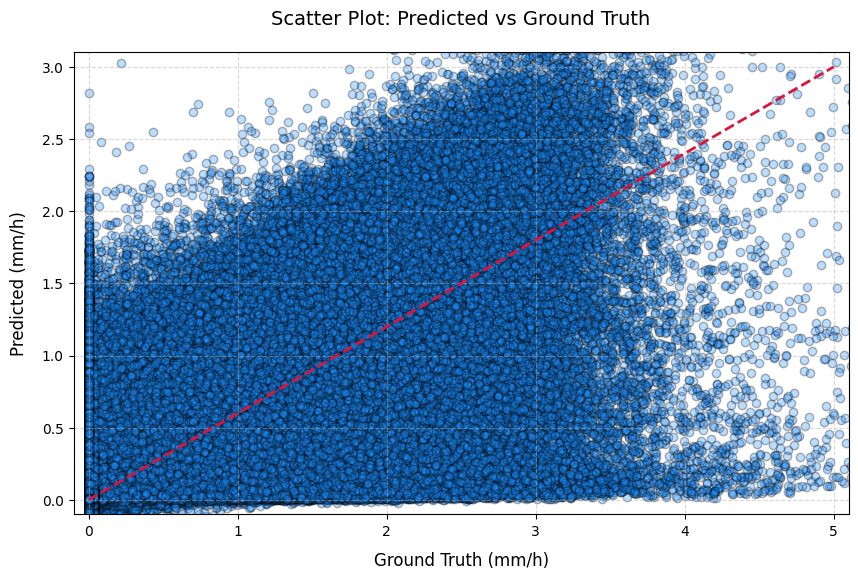

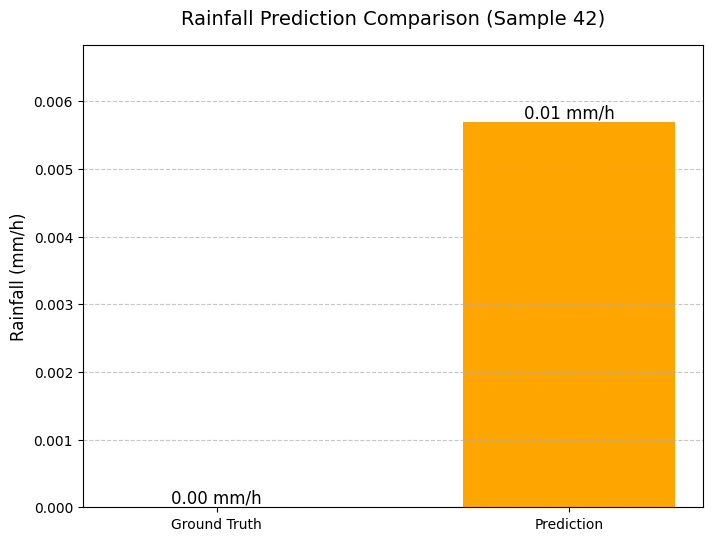

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:42:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt

# 1. ĐỌC VÀ CHUẨN BỊ DỮ LIỆU
data_dir = "/kaggle/working/output/"
all_files = [f for f in os.listdir(data_dir) if f.startswith("flattened_") and f.endswith(".npy")]

X, y = [], []
for file in all_files:
    data = np.load(os.path.join(data_dir, file))
    reshaped = data.reshape(-1, 24)
    X.append(reshaped[:, :-1])
    y.append(reshaped[:, -1])

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# 2. CHIA TẬP TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

# 3. TẠO VÀ HUẤN LUYỆN MÔ HÌNH VỚI GPU
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',          # ✅ Sử dụng GPU để huấn luyện
    predictor='gpu_predictor',       # ✅ Sử dụng GPU để dự đoán
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=20,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# 4. ĐÁNH GIÁ MÔ HÌNH
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"\nRMSE: {rmse:.4f}")

# === VISUALIZATION ===
# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.3, c='dodgerblue', edgecolor='k')
plt.plot([0, 5], [0, 3], '--', c='crimson', lw=2)
plt.xlabel('Ground Truth (mm/h)', fontsize=12, labelpad=10)
plt.ylabel('Predicted (mm/h)', fontsize=12, labelpad=10)
plt.title('Scatter Plot: Predicted vs Ground Truth', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-0.1, 5.1)
plt.ylim(-0.1, 3.1)
plt.savefig('scatter_plot.png', bbox_inches='tight', dpi=300)
plt.show()

# Biểu đồ so sánh cho 1 sample
sample_idx = 42  # Có thể thay đổi chỉ số
sample = X_test[sample_idx].reshape(1, -1)
prediction = model.predict(sample)[0]
true_value = y_test[sample_idx]

plt.figure(figsize=(8, 6))
bars = plt.bar(['Ground Truth', 'Prediction'], [true_value, prediction], 
               color=['teal', 'orange'], width=0.6)

plt.ylabel('Rainfall (mm/h)', fontsize=12)
plt.title(f'Rainfall Prediction Comparison (Sample {sample_idx})', fontsize=14, pad=15)
plt.ylim(0, max([true_value, prediction])*1.2)

# Thêm giá trị số
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} mm/h',
             ha='center', va='bottom',
             fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('prediction_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

# 5. LƯU MÔ HÌNH
model.save_model("xgboost_rainfall_gpu.model")


Visualizing predictions for: flattened_2020101122.npy


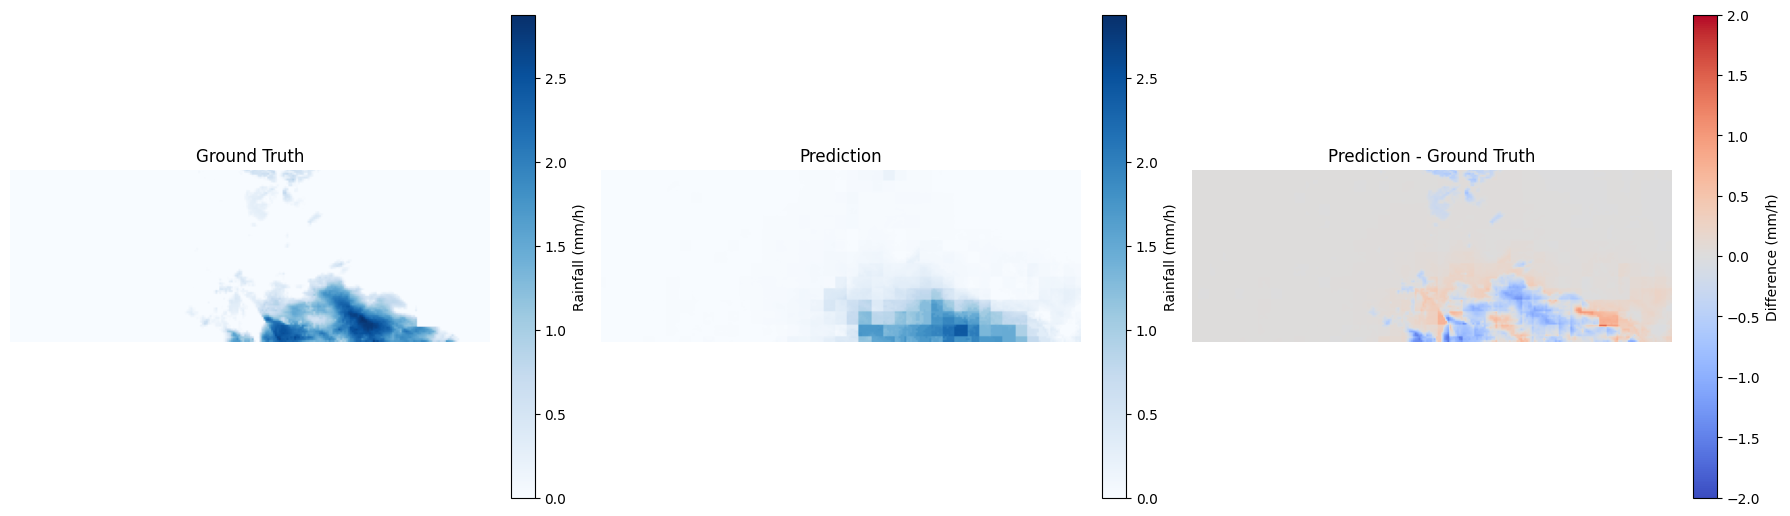

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ... [Phần code đọc dữ liệu, train model ở trên] ...

# ========== VẼ ẢNH DỰ ĐOÁN CHO 1 THỜI ĐIỂM BẤT KỲ ==========
def predict_and_visualize_timestamp(timestamp_file):
    """
    Dự đoán và visualize cho một timestamp cụ thể
    :param timestamp_file: Đường dẫn đến file .npy của timestamp cần dự đoán
    """
    # Load dữ liệu timestamp
    data = np.load(timestamp_file)
    reshaped = data.reshape(-1, 24)
    
    # Tách features và target
    X_timestamp = reshaped[:, :-1]
    y_true = reshaped[:, -1].reshape(90, 250)  # Ground truth
    
    # Dự đoán
    y_pred = model.predict(X_timestamp).reshape(90, 250)
    
    # Tạo figure
    plt.figure(figsize=(18, 6))
    
    # Chuẩn hóa colormap chung
    vmax = max(y_true.max(), y_pred.max())
    norm = Normalize(vmin=0, vmax=vmax)
    
    # Plot ground truth
    plt.subplot(1, 3, 1)
    plt.imshow(y_true, cmap='Blues', norm=norm)
    plt.colorbar(label='Rainfall (mm/h)', fraction=0.046, pad=0.04)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot prediction
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred, cmap='Blues', norm=norm)
    plt.colorbar(label='Rainfall (mm/h)', fraction=0.046, pad=0.04)
    plt.title('Prediction')
    plt.axis('off')
    
    # Plot difference
    plt.subplot(1, 3, 3)
    diff = y_pred - y_true
    plt.imshow(diff, cmap='coolwarm', vmin=-2, vmax=2)
    plt.colorbar(label='Difference (mm/h)', fraction=0.046, pad=0.04)
    plt.title('Prediction - Ground Truth')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_map.png', bbox_inches='tight', dpi=200)
    plt.show()

# Chọn một file ngẫu nhiên để demo
sample_file = np.random.choice(all_files)
print(f"Visualizing predictions for: {sample_file}")
predict_and_visualize_timestamp(os.path.join(data_dir, sample_file))